## IE 5561 Project 2 
### Title: Text Mining and Sentiment Analysis of Covid-19 related Tweets
#### Authors: Anthony Roberts & Abdalla Osman

Objectives of this project include:
1. Build a data pipeline to stream real-time Twitter Data in R
2. Extract historical Twitter data - using Hydrate or Twarc
3. Perform text mining and exploratory analyses on Tweets relating to Covid-19
  - Geospatial analysis - Putting Twitter data on the map
  - Content analysis - Word Clouds 
  - Frequency of tweets over time
  - Popular terms of #covid19 tweets over time
  - Important words using TF-IDF
4. Perform Sentiment Analyses - Unigram/Bigram
  - Analyze Sentiments Over Time
  - Pairwise Correlations
5. Topic modeling: 
  - Latent Dirichlet Allocation (LDA) algorithm

In [36]:
# Import necessary libraries and functions
# data importing and processing
library(RSQLite) #query data from SQlite database
library(rtweet) #for interacting with Twitter API

# manipulation and wrangling
library(dplyr) #Data manipulation (also included in the tidyverse package)
library(tidytext) #Text mining
library(tidyr) #Spread, separate, unite, text mining (also included in the tidyverse package)
library(widyr) #Use for pairwise correlation
library(tm) #text mining
library(lubridate) #work with dates
library(qdap) #text mining
library(topicmodels) #for topic modeling


# Visualizations
library(ggplot2) #Visualizations (also included in the tidyverse package)
library(ggrepel) #`geom_label_repel`
library(gridExtra) #`grid.arrange()` for multi-graphs
library(knitr) #Create nicely formatted output tables
library(kableExtra) # create a nicely formated HTML table
library(wordcloud2) #create nice wordclouds
library(ggplot2) #for visualizations
library(maps) #creating maps
source("twitter_listener.R") #tokens for Twitter APi (needed for stream_tweets)
source("google_maps.R") #tokens for Google Maps API (needed for maps function)

### Data Extraction and Preprocessing

We use the stream_tweet() function from the rtweet package to stream tweets from Twitter. In order to accomplish this, a twitter developer account is needed. After obtaining the Twitter API tokens we are able to use the function to request data from the Twitter API. <br>
<br>
The twitter API sends the data as a .json file. To enable processing and analyzing of the data in R we need to parse the data into a R data using the parse_stream() function. This usually breaks with large datasets after long streams so we have a recover_stream function that takes the .json file as an input and removes some of the misbehaving characters from the stream. <br>
<br>
After obtaining the Twitter stream.json file, we need to normalize, transform and clean the tweet content to allow text analysis. We created a normalize_text() which performs a series of processes that remove HTML tags, URLS, extra whitespace, etc.  <br>
<br>
This data is then transformed and condensed to remove retweets and selecting only the data that we care about for text analysis. <br>

In [2]:
# Function to normalize and clean twitter data after stream
normalize_text <- function(text){
  # Keep only ASCII characters
  text = iconv(text, "latin1", "ASCII", sub="")
  
  # Convert to lower case characters
  text = tolower(text)
  
  # Remove any HTML tags
  text = gsub("<.*?>", " ", text)
  
  # Remove URLs
  text = gsub("\\s?(f|ht)(tp)(s?)(://)([^\\.]*)[\\.|/](\\S*)", "", text)
  
  # Keep letters and numbers only
  text = gsub("[^[:alnum:]]", " ", text)
  
  # Remove stop words
  text = removeWords(text,c("rt","gt",stopwords("en")))
  
  # Remove any extra white space
  text = stripWhitespace(text)                                 
  text = gsub("^\\s+|\\s+$", "", text)                         
  
  return(text)
}

In [3]:
# Recovers Twitter damaged stream data (JSON file) into parsed data frame.
recover_stream <- function(path, dir = NULL, verbose = TRUE) {
  
  # read file and split to tweets
  lines <- readChar(path, file.info(path)$size, useBytes = TRUE)
  tweets <- stringi::stri_split_fixed(lines, "\n{")[[1]]
  tweets[-1] <- paste0("{", tweets[-1])
  tweets <- tweets[!(tweets == "" | tweets == "{")]
  
  # remove misbehaving characters
  tweets <- gsub("\r", "", tweets, fixed = TRUE)
  tweets <- gsub("\n", "", tweets, fixed = TRUE)
  
  # write tweets to disk and try to read them in individually
  if (is.null(dir)) {
    dir <- paste0(tempdir(), "/tweets/")
    dir.create(dir, showWarnings = FALSE)
  }
  
  if (verbose) {
    pb <- progress::progress_bar$new(
      format = "Processing tweets [:bar] :percent, :eta remaining",
      total = length(tweets), clear = FALSE
    )
    pb$tick(0)
  }
  
  tweets_l <- lapply(tweets, function(t) {
    pb$tick()
    id <- unlist(stringi::stri_extract_first_regex(t, "(?<=id\":)\\d+(?=,)"))[1]
    f <- paste0(dir, id, ".json")
    writeLines(t, f, useBytes = TRUE)
    out <- tryCatch(rtweet::parse_stream(f),
                    error = function(e) {})
    if ("tbl_df" %in% class(out)) {
      return(out)
    } else {
      return(id)
    }
  })
  
  # test which ones failed
  test <- vapply(tweets_l, is.character, FUN.VALUE = logical(1L))
  bad_files <- unlist(tweets_l[test])
  
  # clean up
  unlink(dir, recursive = TRUE)
  
  # return good tweets
  return(dplyr::bind_rows(tweets_l[!test]))
}

In [4]:
# Function to transform and remove retweets from streaming Twitter data
transform_and_clean_tweets <- function(filename, remove_rts = TRUE){
  
df <- tryCatch(
    expr = {
      # Parse the .json file given by the Twitter API into an R data frame
      df <- parse_stream(filename)
    },
    error = function(e) {
      message("There was an error parsing, ", filename)
      message(e)
      # Recovers any damaged streams and parses into data frame
        df <- recover_stream(filename)
        #return(df)
    }
  )

  # If remove_rts = TRUE, filter out all the retweets from the stream
  if(remove_rts == TRUE){
    df <- dplyr::filter(df,df$is_retweet == FALSE)
  }
  
  # Keep only the tweets that are in English
  df <- dplyr::filter(df, df$lang == "en")
  
  # create lat/lng variables using all available tweet and profile geo-location data
  df <- lat_lng(df)
  
  # Select the features that you want to keep from the Twitter stream and rename them
  # so the names match those of the columns in the Tweet_Data table in our database
  small_df <- df[,c("screen_name","text","created_at","location","lat","lng")]
  names(small_df) <- c("User","Tweet_Content","Date_Created","Location","Latitude","Longitude")
  
  # Finally normalize the tweet text
  small_df$Tweet_Content <- sapply(small_df$Tweet_Content, normalize_text)
  
  # Keep only ASCII characters in location field
  small_df$Location = iconv(small_df$Location, "latin1", "ASCII", sub="")
  
  # Return the processed data frame
  return(small_df)
}

For this project, we streamed data from April 24. But we also wanted to do a little historical analysis from the beginning of the year. Due to the limitations of Twitters API, search_tweets() only allows Twitter data from 6-9 days worth back. So we used Hydrator and Twarc to extract tweet content from a public repository of Tweet IDs. We limited the dataset to extract a sample of Covid-19 related tweets from previous months of the year to date. <br>
<br>
We created a SQLite database to store the transformed and cleaned real-time stream tweets from Twitter and the historical Tweet data. This allows for easy access of data. We stream the data every 15 minutes for 1 hour. We normalize, transform and clean the data and load it to the SQLite database. 

In [5]:
# Connect to the SQLite database
conn <- dbConnect(RSQLite::SQLite(), "/Volumes/GoogleDrive/My Drive/IE 5561 Projects/Project 2/Data/Tweet_DB.db")

In [6]:
# DO NOT RUN - Database has already been created and stored in Tweet_DB.db in the Data Folder
# create table for Tweet data
#  dbExecute(conn, "CREATE TABLE Tweet_Data(
#                  Tweet_ID INTEGER PRIMARY KEY,
#                  User TEXT,
#                  Tweet_Content TEXT,
#                  Date_Created INTEGER,
#                  Location TEXT,
#                  Latitude NUMERIC,
#                  Longitude NUMERIC)")

In [7]:
# hastags to query in the real-time Tweet stream
keys <- "#covid19,#coronavirus,#covid,#coronavirusoutbreak"

The cell below commences the process to stream tweets from Twitter through the Twitter API. In order to run this cell and use the rtweet, you need set up a Twitter and gather a consumer key, consumer secret key, access token, and access token secret key. Once you have that, the following cell will stream tweets for the alloted time specified in the streamtime variable, clean, normalize, tranform the tweets and then load the cleanted tweets to the Tweets_DB.db SQlite databse.

In [8]:
# stream the data from Twitter 
# modified streamtime to 30 seconds for the sake of running the report
# Initialize the streaming tally
counter <- 0

# Initialize a while loop that stops when the number of hours you want to stream tweets for is exceeded
while(counter <= 2){
  # Set the stream time (in seconds) for each iteration
  streamtime <- 30
  
  # Create the file name where the 2 hour stream will be stored. Twitter API outputs a .json file.
  filename <- paste0("covid_stream_",format(Sys.time(),'%d_%m_%Y__%H_%M_%S'),".json")
  
  # Stream Tweets containing the desired keys for the specified amount of time
  stream_tweets(q = keys, timeout = streamtime, file_name = filename,
                token = token, parse = FALSE)

    # Clean the streamed tweets and select the desired fields
  clean_stream <- transform_and_clean_tweets(filename, remove_rts = TRUE)
  
  # Append the streamed tweets to the Tweet_Data table in the SQLite database
  dbWriteTable(conn, "Tweet_Data", clean_stream, append = T)
  
  # Delete the .json file from stream
  file.remove(filename)
  
  # Add the counter to the tally
  counter <- counter + 1
 }

Streaming tweets for 30 seconds...

Finished streaming tweets!

streaming data saved as covid_stream_01_05_2020__14_03_06.json

Streaming tweets for 30 seconds...

Finished streaming tweets!

streaming data saved as covid_stream_01_05_2020__14_03_40.json

Streaming tweets for 30 seconds...

Finished streaming tweets!

streaming data saved as covid_stream_01_05_2020__14_04_14.json



In [9]:
# test data connection, loading and transform
data_test <- dbGetQuery(conn, "SELECT * FROM Tweet_Data LIMIT 10")

#number of unique rows
(unique_rows <- dbGetQuery(conn, "SELECT COUNT() AS Total FROM Tweet_Data"))

# convert dates to correct datetime format
data_test$Date_Created <- as.POSIXct(data_test$Date_Created, origin = "1970-01-01")

data_test

Total
<int>
89738


Tweet_ID,User,Tweet_Content,Date_Created,Location,Latitude,Longitude
<int>,<chr>,<chr>,<dttm>,<chr>,<dbl>,<dbl>
1,TBlackwe85,china downplay coronavirus outbreak early,2020-01-27 18:00:00,"Washington, DC/Baltimore, MD",NA,NA
2,VIKBataille,speak resident inside wuhan epicentre coronavirus ou via youtube,2020-01-27 18:00:00,"Sydney, New South Wales",NA,NA
3,VIKBataille,follow cgtn reporters scene virus hit wuhan city via youtube,2020-01-27 18:00:00,"Sydney, New South Wales",NA,NA
4,kelf89,someone sneaked back sichuan wuhan despite lockdown order place whistle blower got throat slit broad daylight wuhan traveller,2020-01-27 18:00:00,,NA,NA
5,rakeshgrn,special air india plane ready get indians trapped wuhan,2020-01-27 18:00:00,,NA,NA
6,BGMK_III,msm reported coronavirus originated wuhan chinas covert biological warfare programs located core coronavirus sars supplied china canadas incompetent liberal government possible,2020-01-27 18:00:00,Undisclosed Bunker,NA,NA
7,LeianneWright,spoke someone city wuhan told manmade virus believe meant specifically lower populations supposed sent us well others speculation belief population increase killing planet,2020-01-27 18:00:00,"Odessa, TX",NA,NA
8,Ashley78189293,ochealth probation period 2 14 days wait see infected instead let people start prepare advance least kids china provinces people hubei wuhan will stay home self quarantine,2020-01-27 18:00:00,,NA,NA
9,yperic,trump offers china help needed wuhan virus toll hits 81,2020-01-27 18:00:00,Singapore,NA,NA


### Geospatial Analysis

In [10]:
# check location of tweets around the world
# query all tweets from database
covid_tweets <- dbGetQuery(conn, "SELECT * FROM Tweet_Data")

Warning message:
“Removed 88100 rows containing missing values (geom_point).”


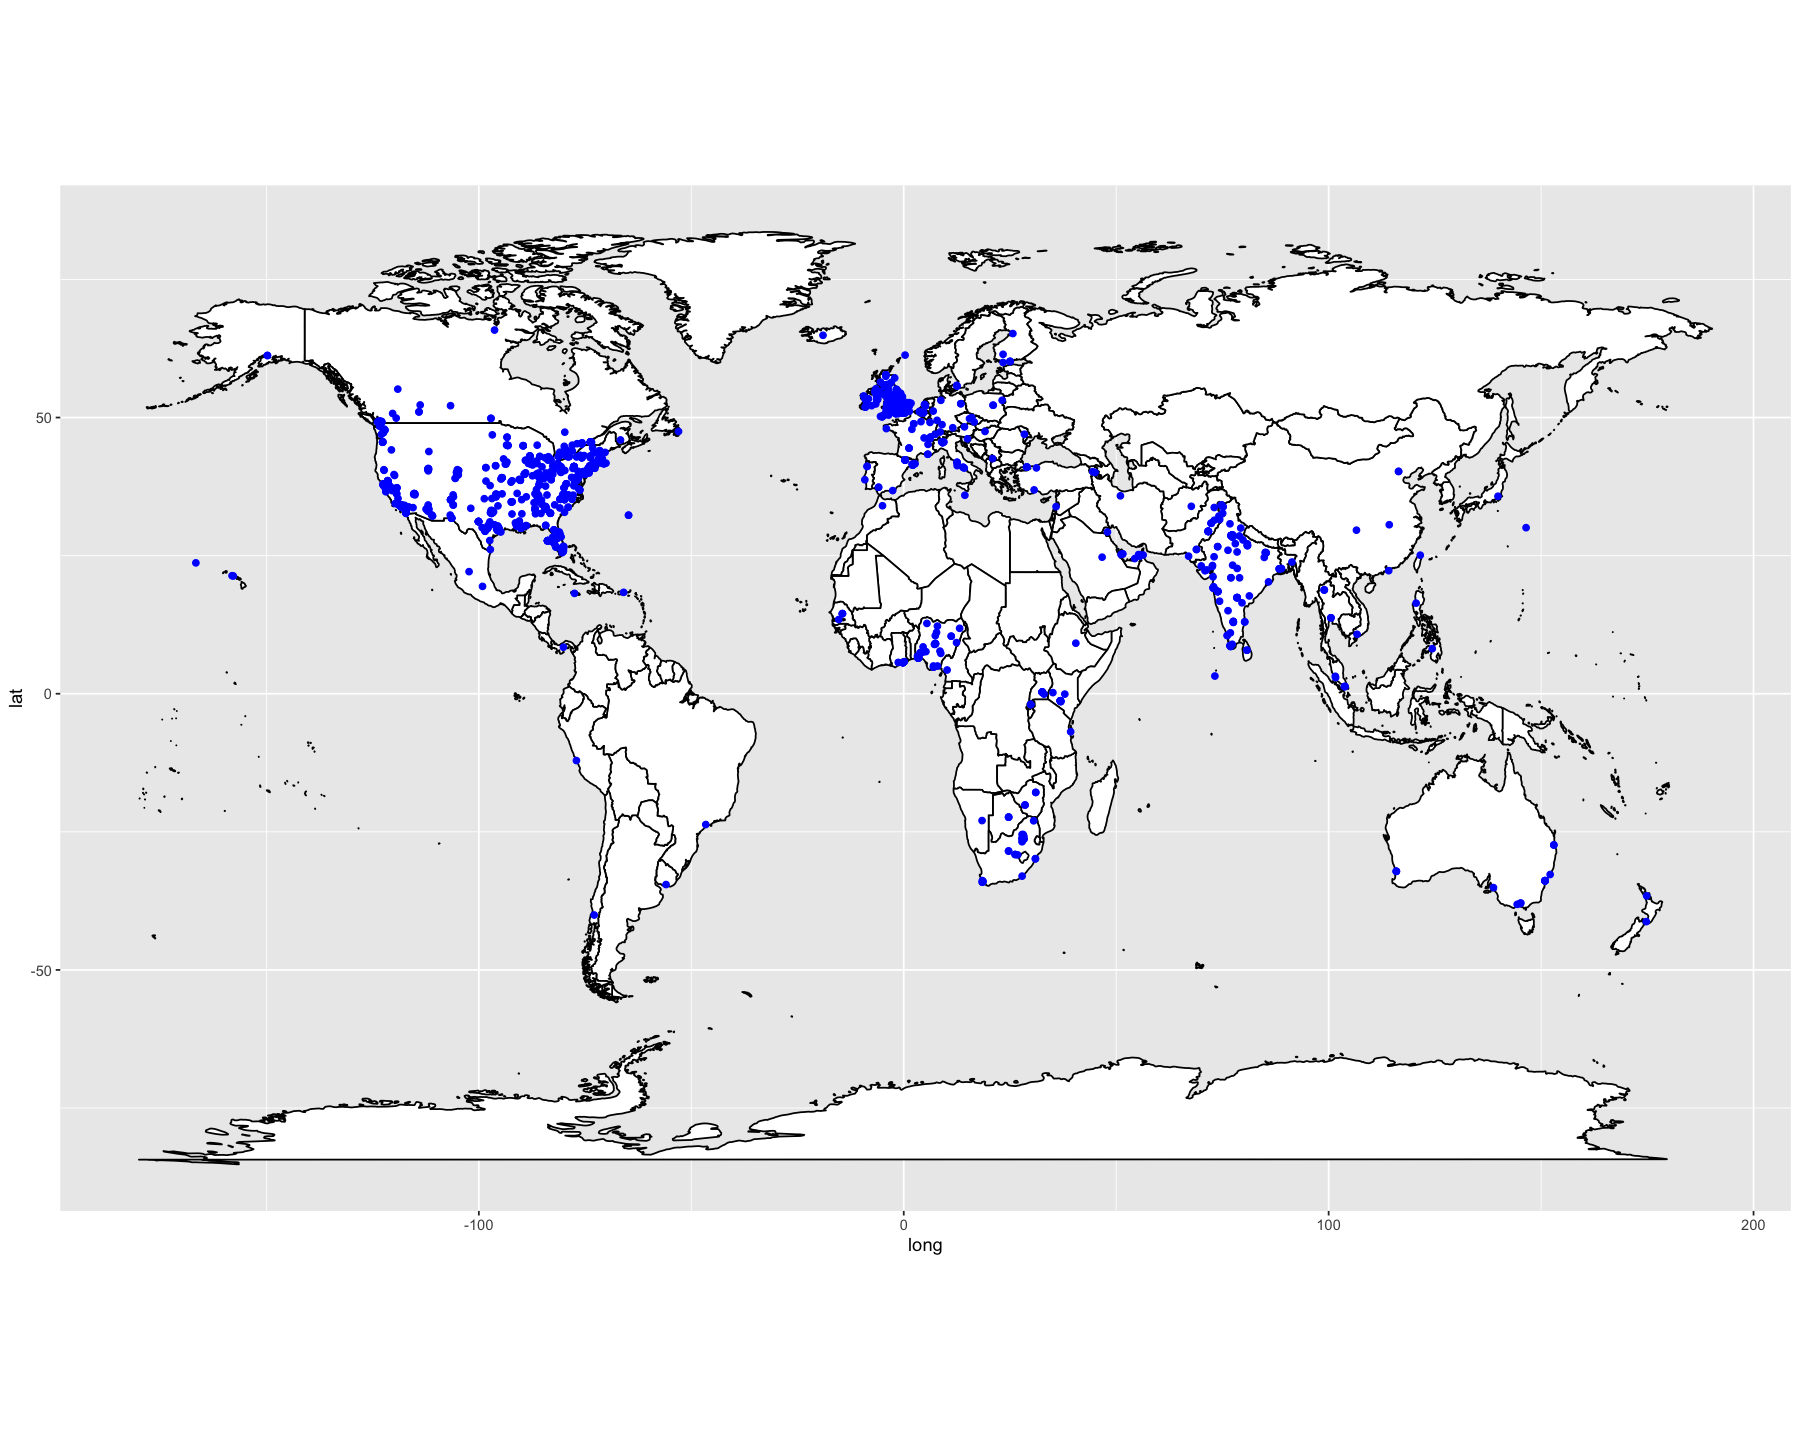

In [37]:
# creating world and usa map objects
world <- map_data("world")
usa <- map_data("state")

# plot world boundaries
gg1 <- ggplot() + 
  geom_polygon(data = world, aes(x=long, y = lat, group = group), fill = 'white', color = 'black') + 
coord_fixed(1.3)
gg1 + geom_point(data = covid_tweets, aes(x = Longitude, y = Latitude), color = "blue", size = 1.5)
options(repr.plot.width=15, repr.plot.height=12)

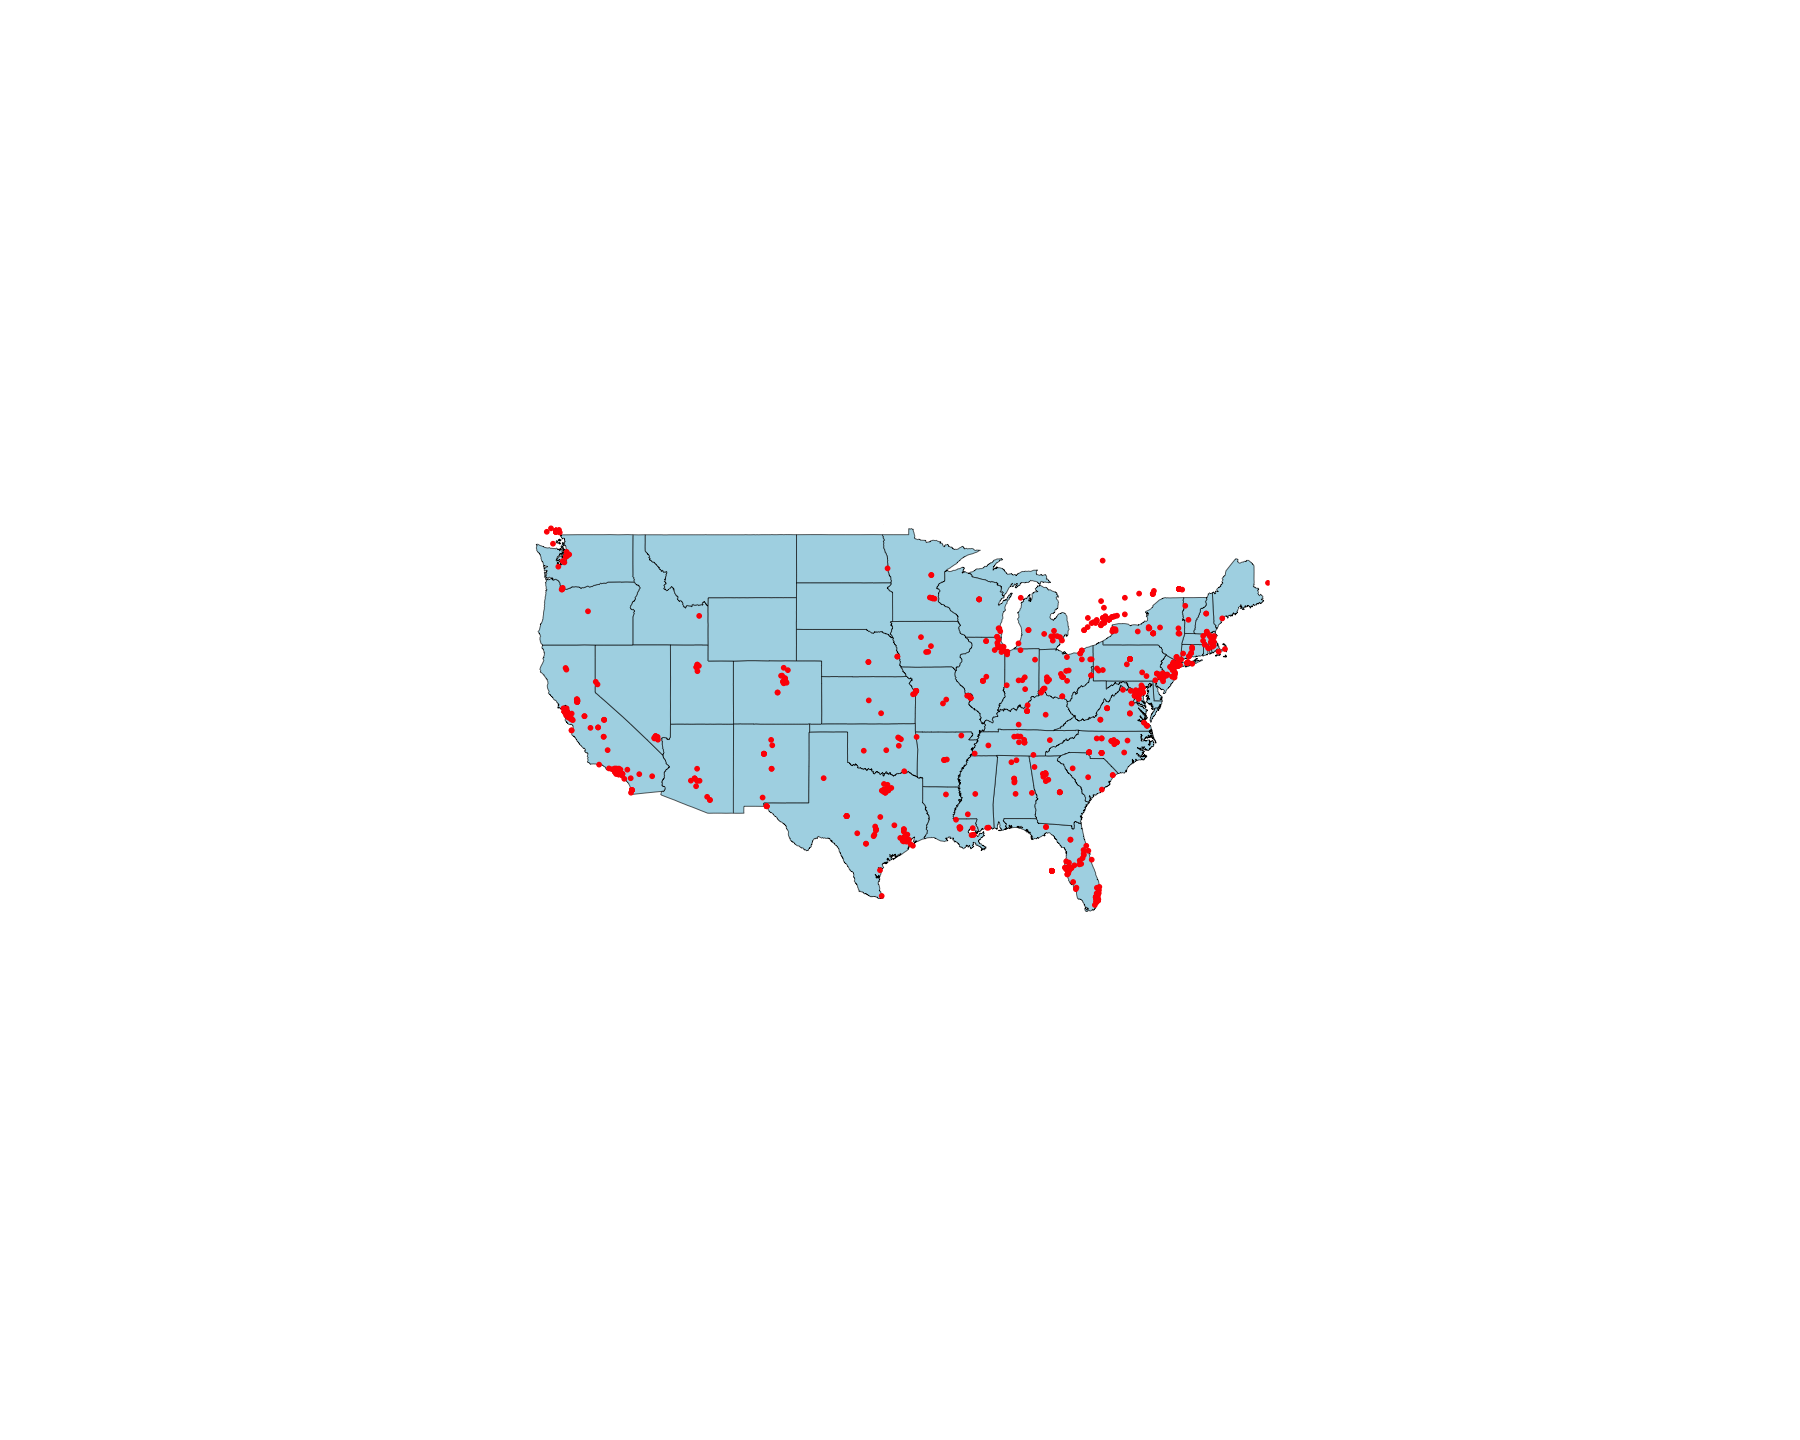

In [12]:
#plot states boundaries
maps::map(database = "state", lwd = .5, fill = TRUE, col = "light blue")

# plot lat and lng points onto usa map
with(covid_tweets, points(Longitude, Latitude, pch = 20, cex = .75, col = " red"))
options(repr.plot.width=15, repr.plot.height=12)

### Content Analysis

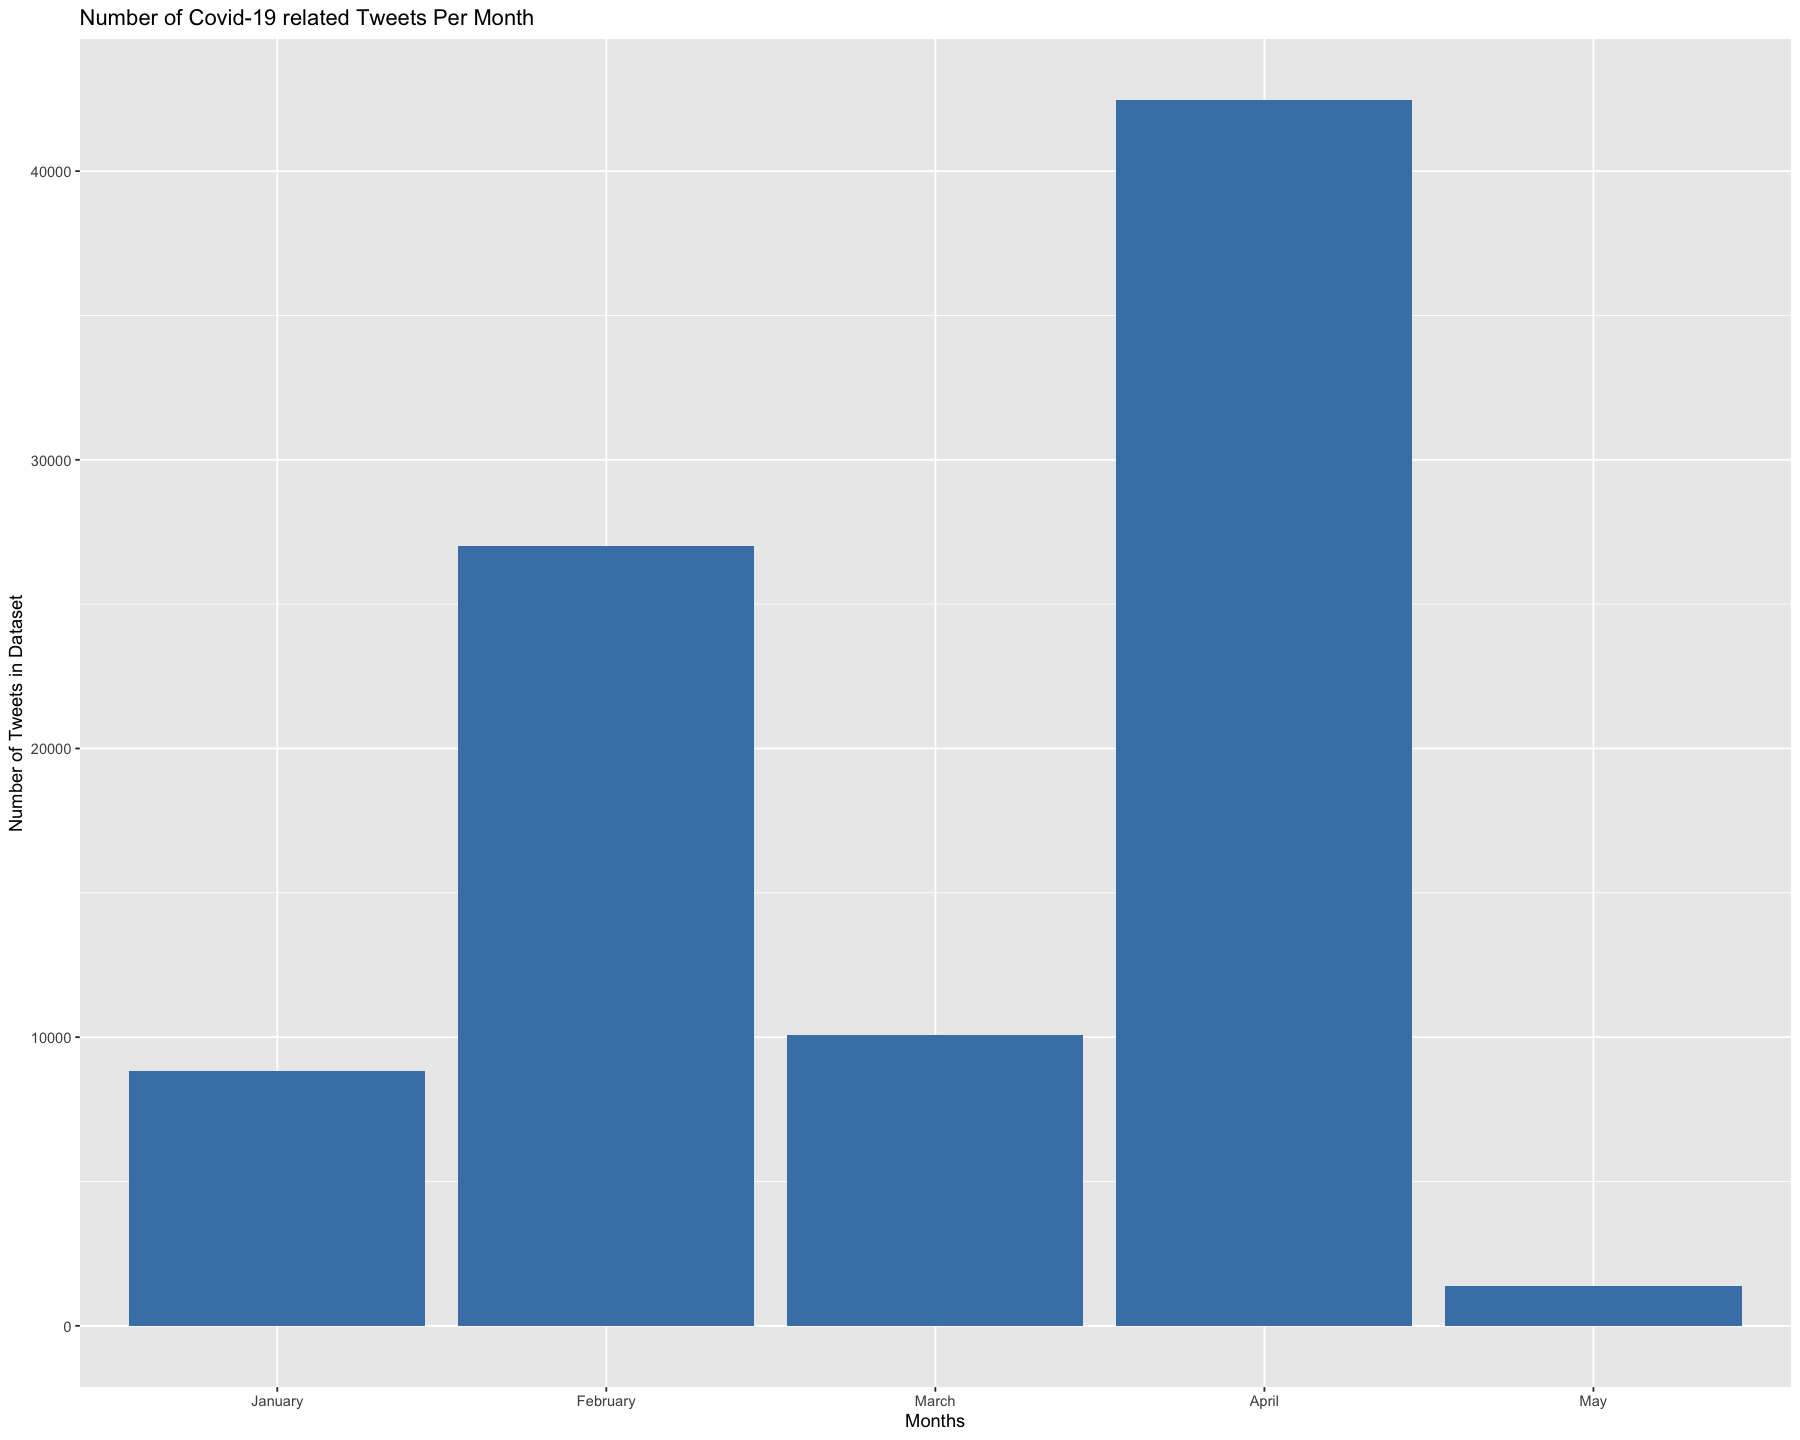

In [13]:
# convert date column integer into POSIXct format
covid_tweets$Date_Created <- as.POSIXct(covid_tweets$Date_Created, origin = "1970-01-01")
covid_tweets <- covid_tweets %>%
  mutate(day = day(Date_Created),
           month = month(Date_Created, label = TRUE, abbr = FALSE),
           hour = hour(Date_Created)) 

# group by month
covid_tweets_ts <- covid_tweets %>%
  group_by(month) %>%
  tally()

# plot number of tweets per month
ggplot(covid_tweets_ts) +
  geom_bar(aes(x = month, y = n ), 
           stat = "identity", 
           fill = "steelblue") +
    xlab("Months") + 
    ylab("Number of Tweets in Dataset") +
    ggtitle("Number of Covid-19 related Tweets Per Month")


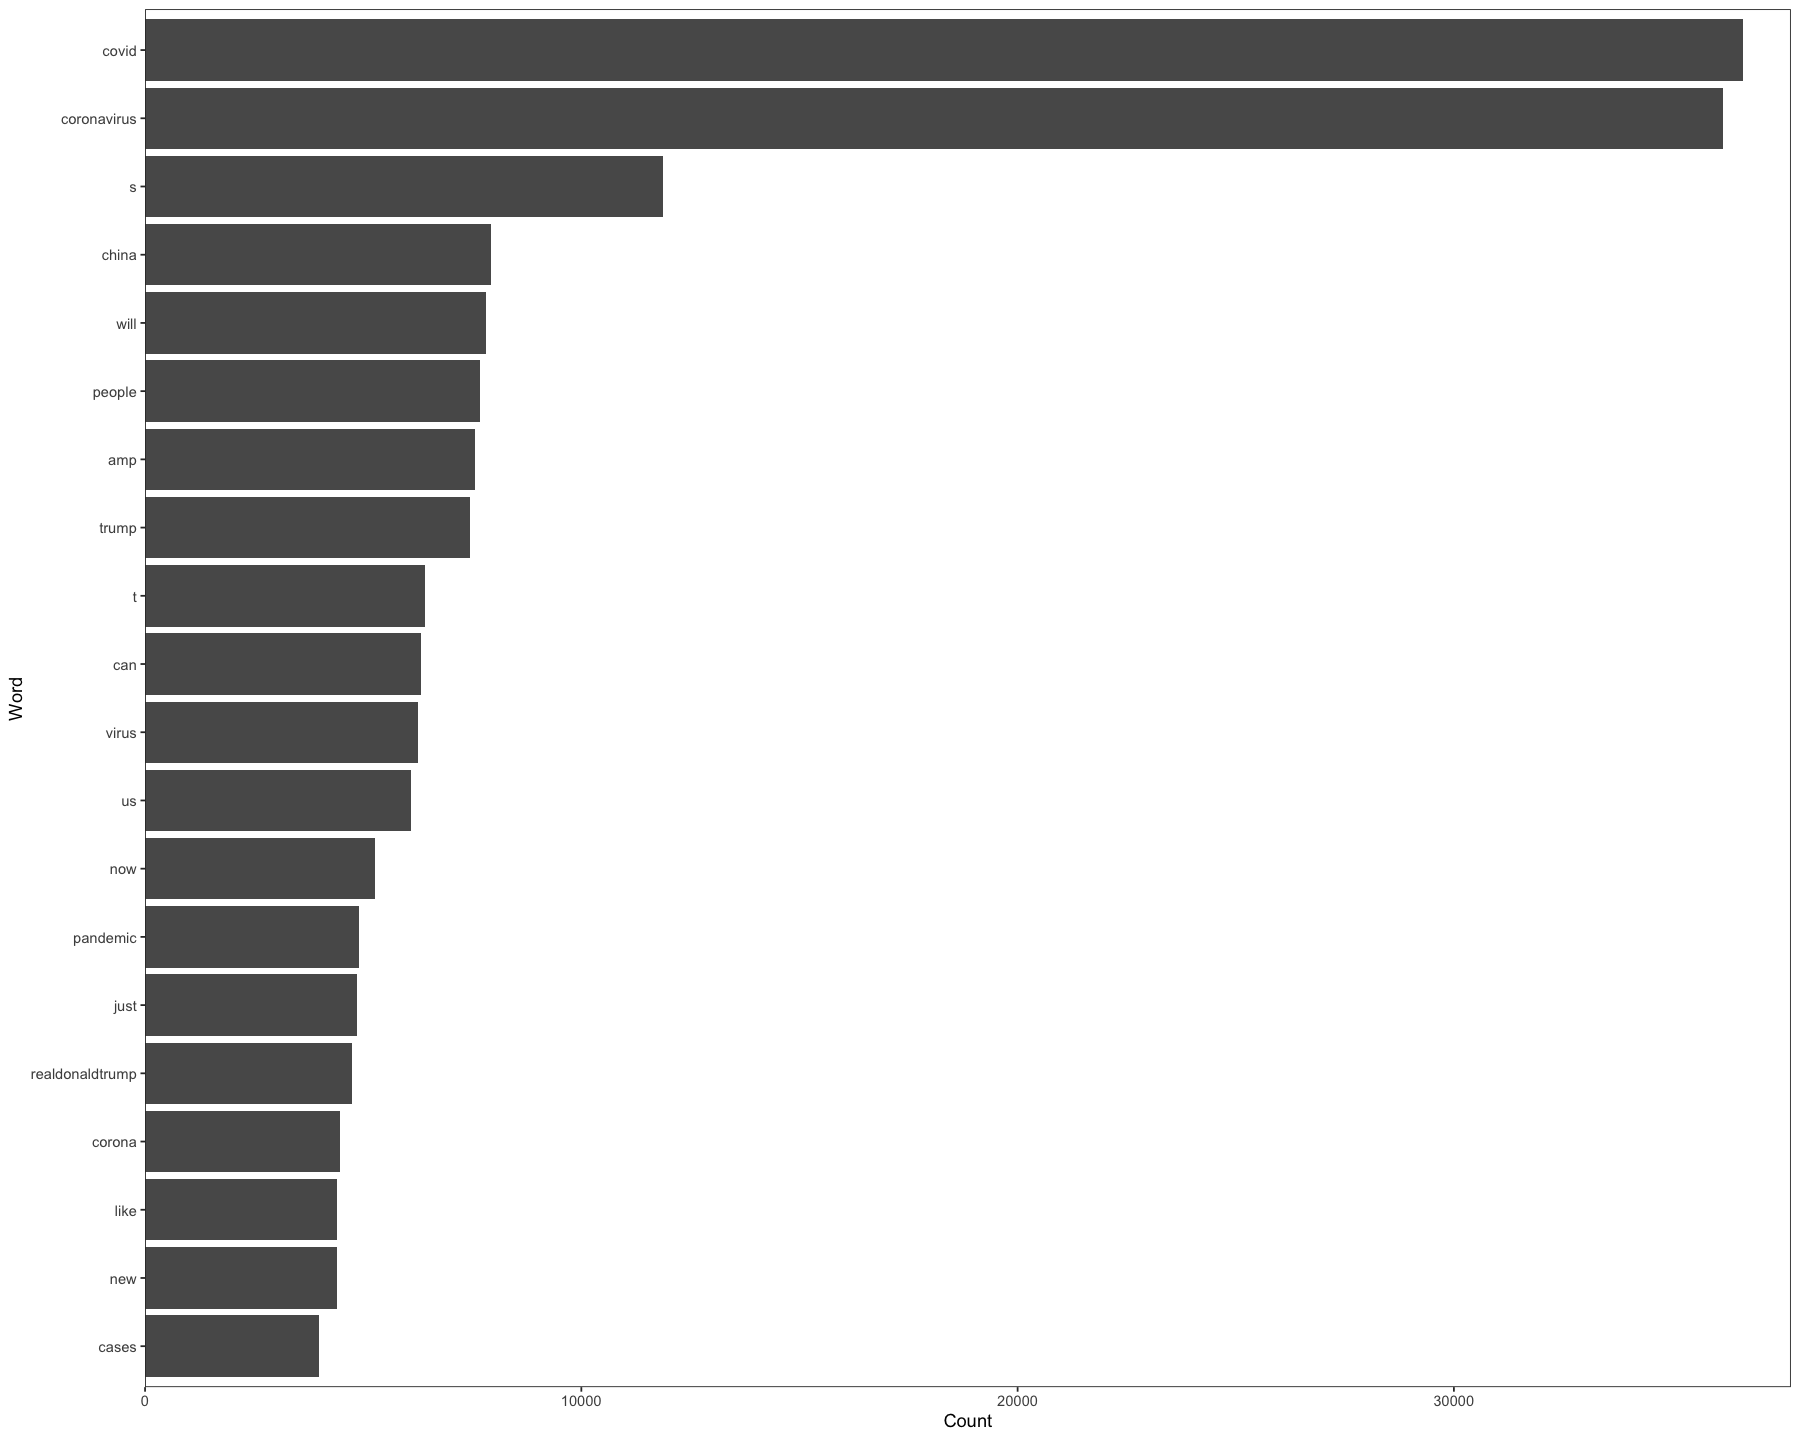

In [14]:
# quick check of frequent terms in all tweets
frequent_terms <- freq_terms(covid_tweets$Tweet_Content)
plot(frequent_terms)

In [15]:
# need to remove more words beyond the standard stop words
undesirable_words <- c("coronavirus", "covid", "corona", "covid19", "virus", "will", "us",
                       "get", "can", "get", "us", "like", "new", "amp", "just", "know", 
                       "going", "take", "50 000", "100 000")

Selecting by n



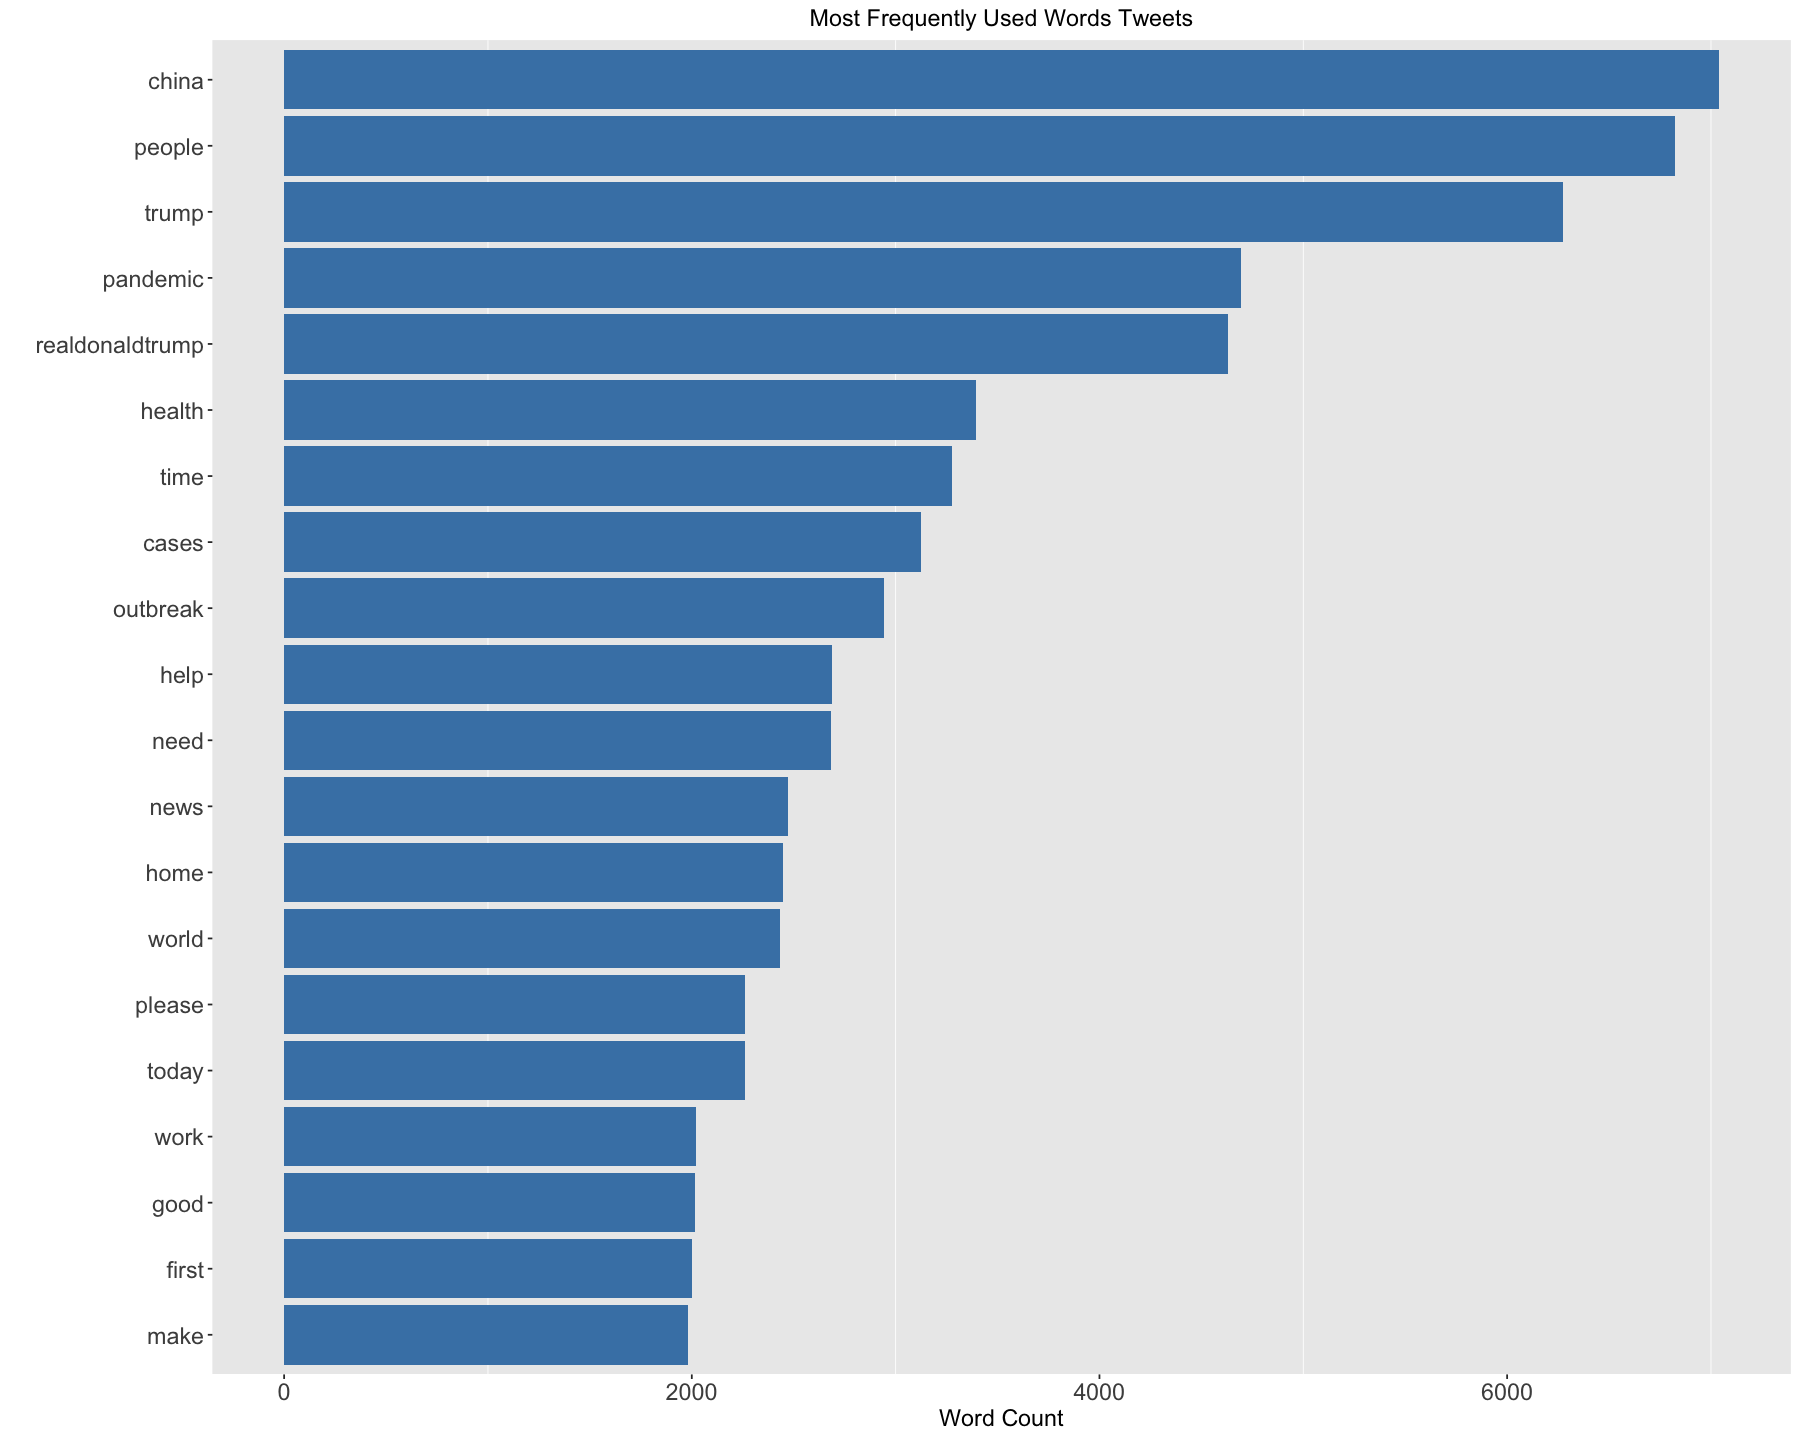

In [16]:
# unnest and remove stop, undesirable and short words
covid_tweets_filtered <- covid_tweets %>%
  unnest_tokens(word, Tweet_Content) %>%
  distinct() %>%
  filter(!word %in% undesirable_words) %>%
  filter(nchar(word) > 3)

# count of words by tweet
covid_tweets_filtered %>%
  count(word, sort = TRUE) %>%
  top_n(20) %>%
  ungroup() %>%
  mutate(word = reorder(word, n)) %>%
  ggplot() +
    geom_col(aes(word, n), fill = "steelblue") +
    theme(legend.position = "none", 
          plot.title = element_text(size = 14, hjust = 0.5),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14),
          panel.grid.major = element_blank()) +
    xlab("") + 
    ylab("Word Count") +
    ggtitle("Most Frequently Used Words Tweets") +
    coord_flip()

In [17]:
# Popular words using TF-IDF
 popular_tfidf_words <- covid_tweets %>%
  unnest_tokens(word, Tweet_Content) %>%
  distinct() %>%
  filter(!word %in% undesirable_words) %>%
  filter(nchar(word) > 3) %>%
  count(month, word, sort = TRUE) %>%
  ungroup() %>%
  bind_tf_idf(word, month, n)

head(popular_tfidf_words, 10)

month,word,n,tf,idf,tf_idf
<ord>,<chr>,<int>,<dbl>,<dbl>,<dbl>
February,china,3967,0.014007125,0,0
February,trump,3072,0.010846960,0,0
April,people,2922,0.005632413,0,0
April,pandemic,2889,0.005568802,0,0
February,realdonaldtrump,2761,0.009748846,0,0
April,trump,2532,0.004880653,0,0
February,people,2317,0.008181122,0,0
April,time,1836,0.003539052,0,0
April,help,1798,0.003465804,0,0


Warning message:
“`show.legend` must be a logical vector.”


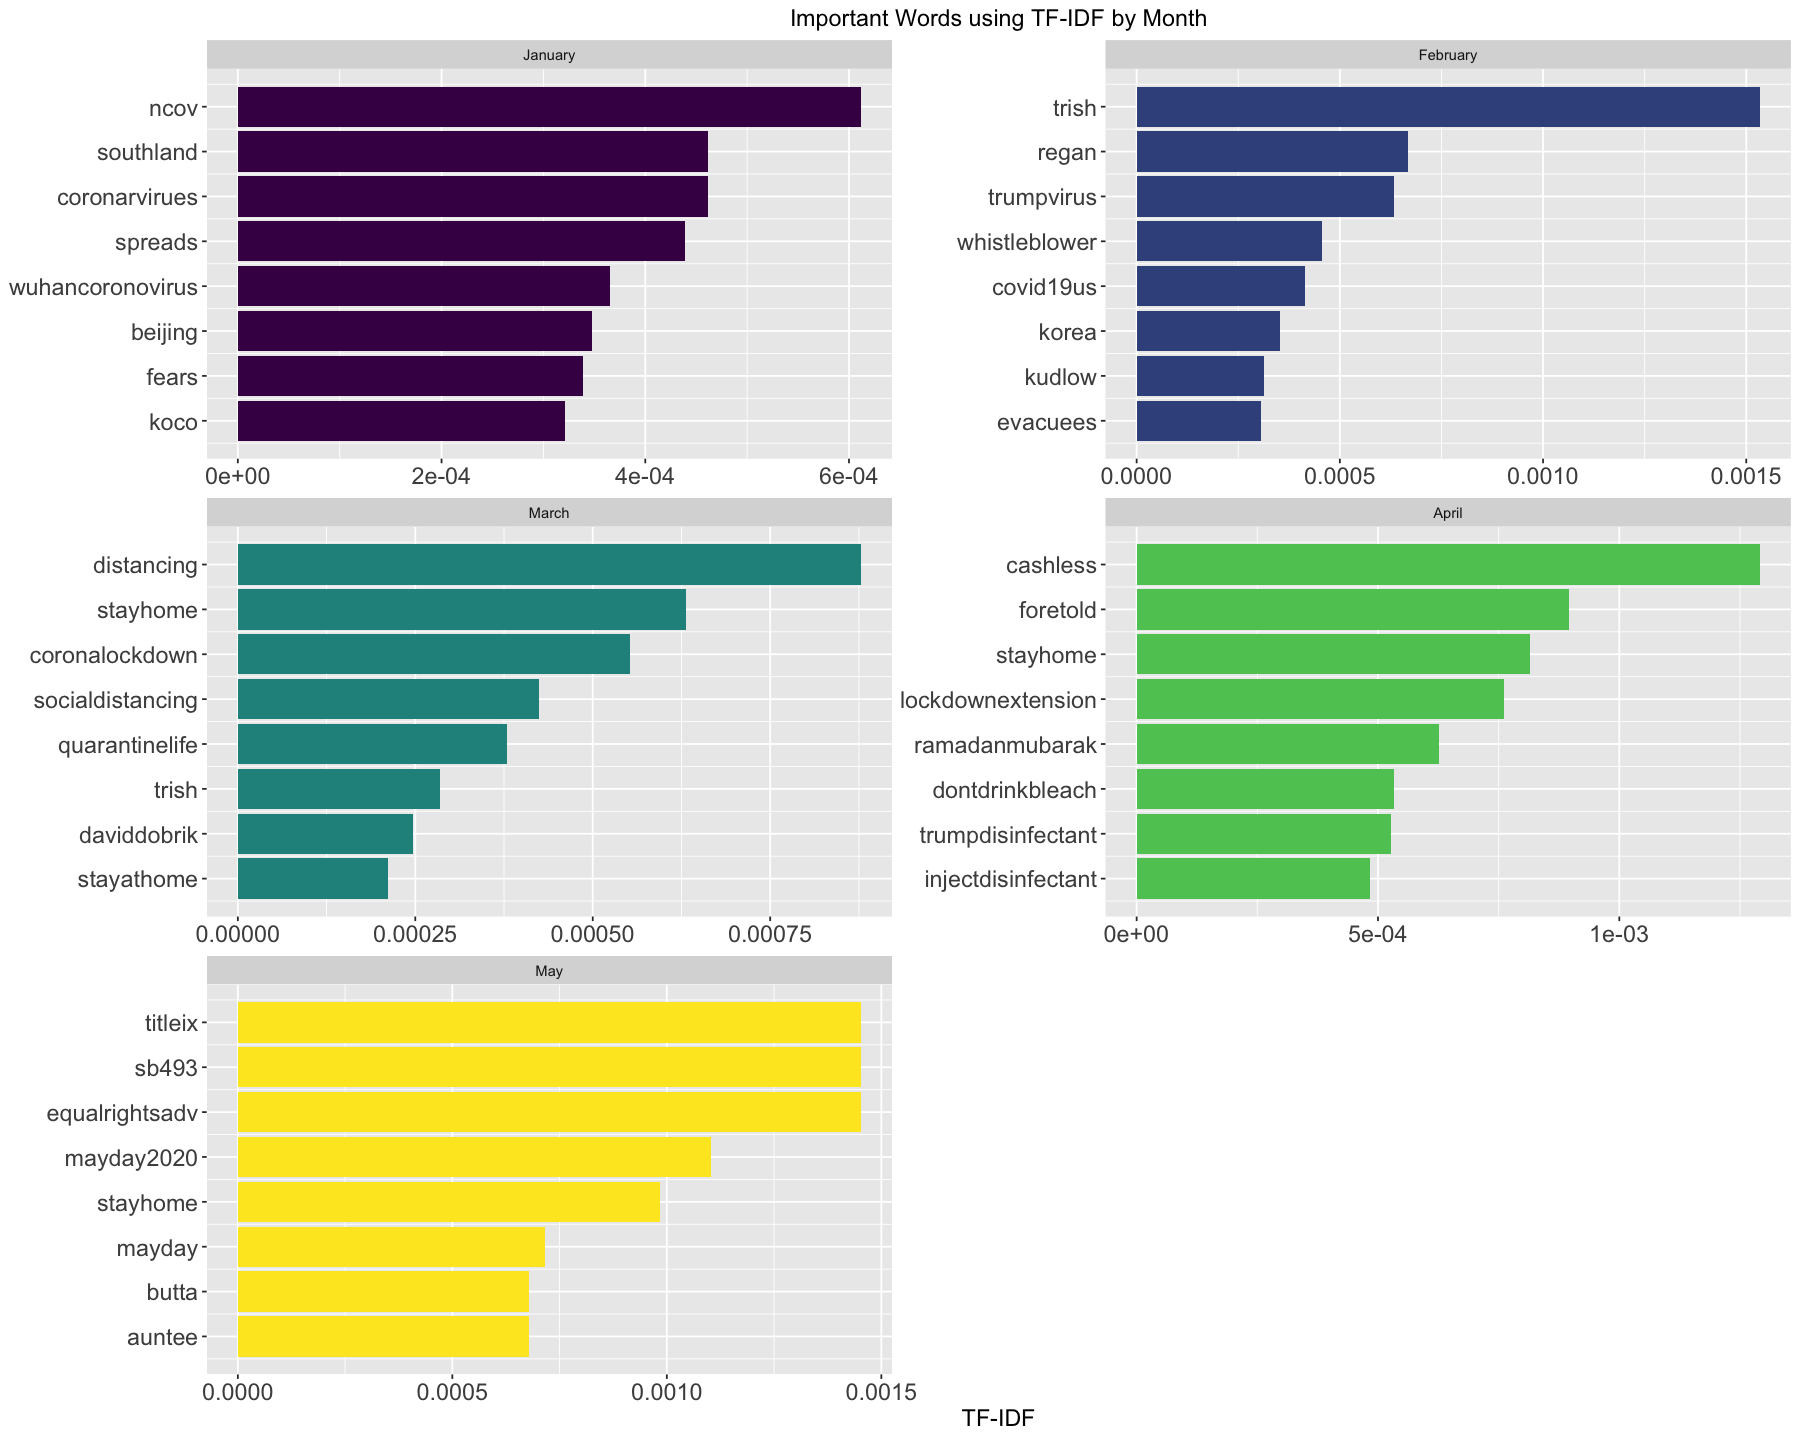

In [18]:
top_popular_tfidf_words <- popular_tfidf_words %>%
  arrange(desc(tf_idf)) %>%
  mutate(word = factor(word, levels = rev(unique(word)))) %>%
  group_by(month) %>% 
  slice(seq_len(8)) %>%
  ungroup() %>%
  arrange(month, tf_idf) %>%
  mutate(row = row_number())

top_popular_tfidf_words %>%
  ggplot(aes(x = row, tf_idf, 
             fill = month)) +
    geom_col(show.legend = NULL) +
    labs(x = NULL, y = "TF-IDF") + 
    ggtitle("Important Words using TF-IDF by Month") +
    facet_wrap(~month, ncol = 2, scales = "free") +
    scale_x_continuous(  # This handles replacement of row 
      breaks = top_popular_tfidf_words$row, # notice need to reuse data frame
      labels = top_popular_tfidf_words$word) +
    theme(legend.position = "none", 
          plot.title = element_text(size = 14, hjust = 0.5),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14)) +
    coord_flip()
options(repr.plot.width=15, repr.plot.height=12)

In [19]:
# create a word cloud
tweet_words_counts <- covid_tweets_filtered %>%
  count(word, sort = TRUE) 

wordcloud2(tweet_words_counts[1:300, ], size = .5)

HTML widgets cannot be represented in plain text (need html)

### Unigram Sentiment Analysis

We perform unigram-based sentiment analysis using the Bing binary sentiment lexicon and NRC categorical sentiment lexicon

In [20]:
# create Sentiment lexicon Datasets from tidytext
# use Bing for binary
covid_bing <- covid_tweets_filtered %>%
  inner_join(get_sentiments("bing"))

# use NRC for categorical sentiments
covid_nrc <- covid_tweets_filtered %>%
  inner_join(get_sentiments("nrc"))

# Since words can appear in multiple categories in NRC, such as Negative/Fear or Positive/Joy, create a subset without the positive and negative categories
covid_nrc_sub <- covid_tweets_filtered %>%
  inner_join(get_sentiments("nrc")) %>%
  filter(!sentiment %in% c("positive", "negative"))

Joining, by = "word"

Joining, by = "word"

Joining, by = "word"



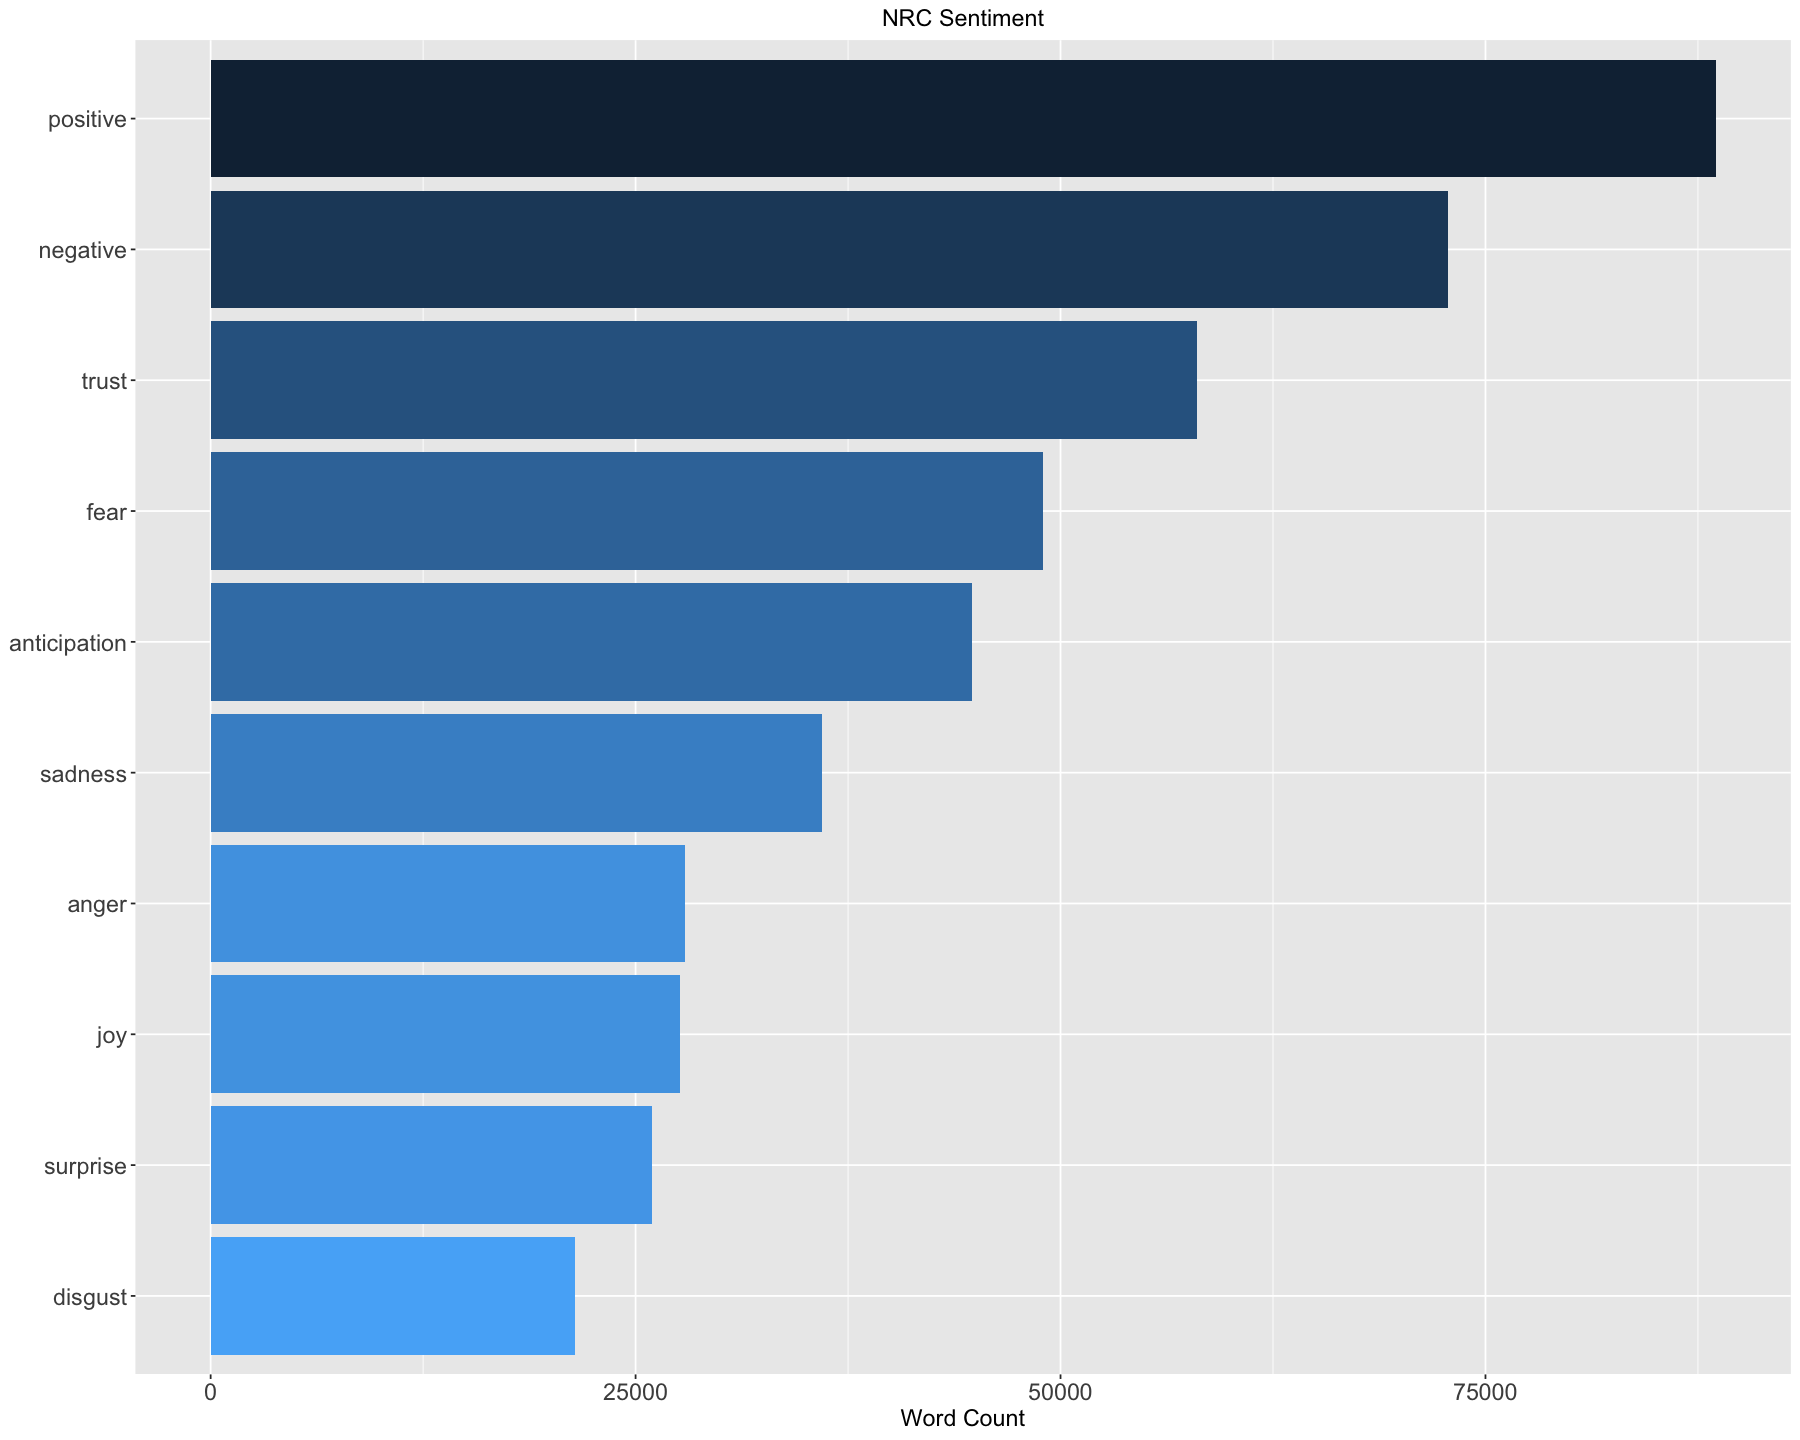

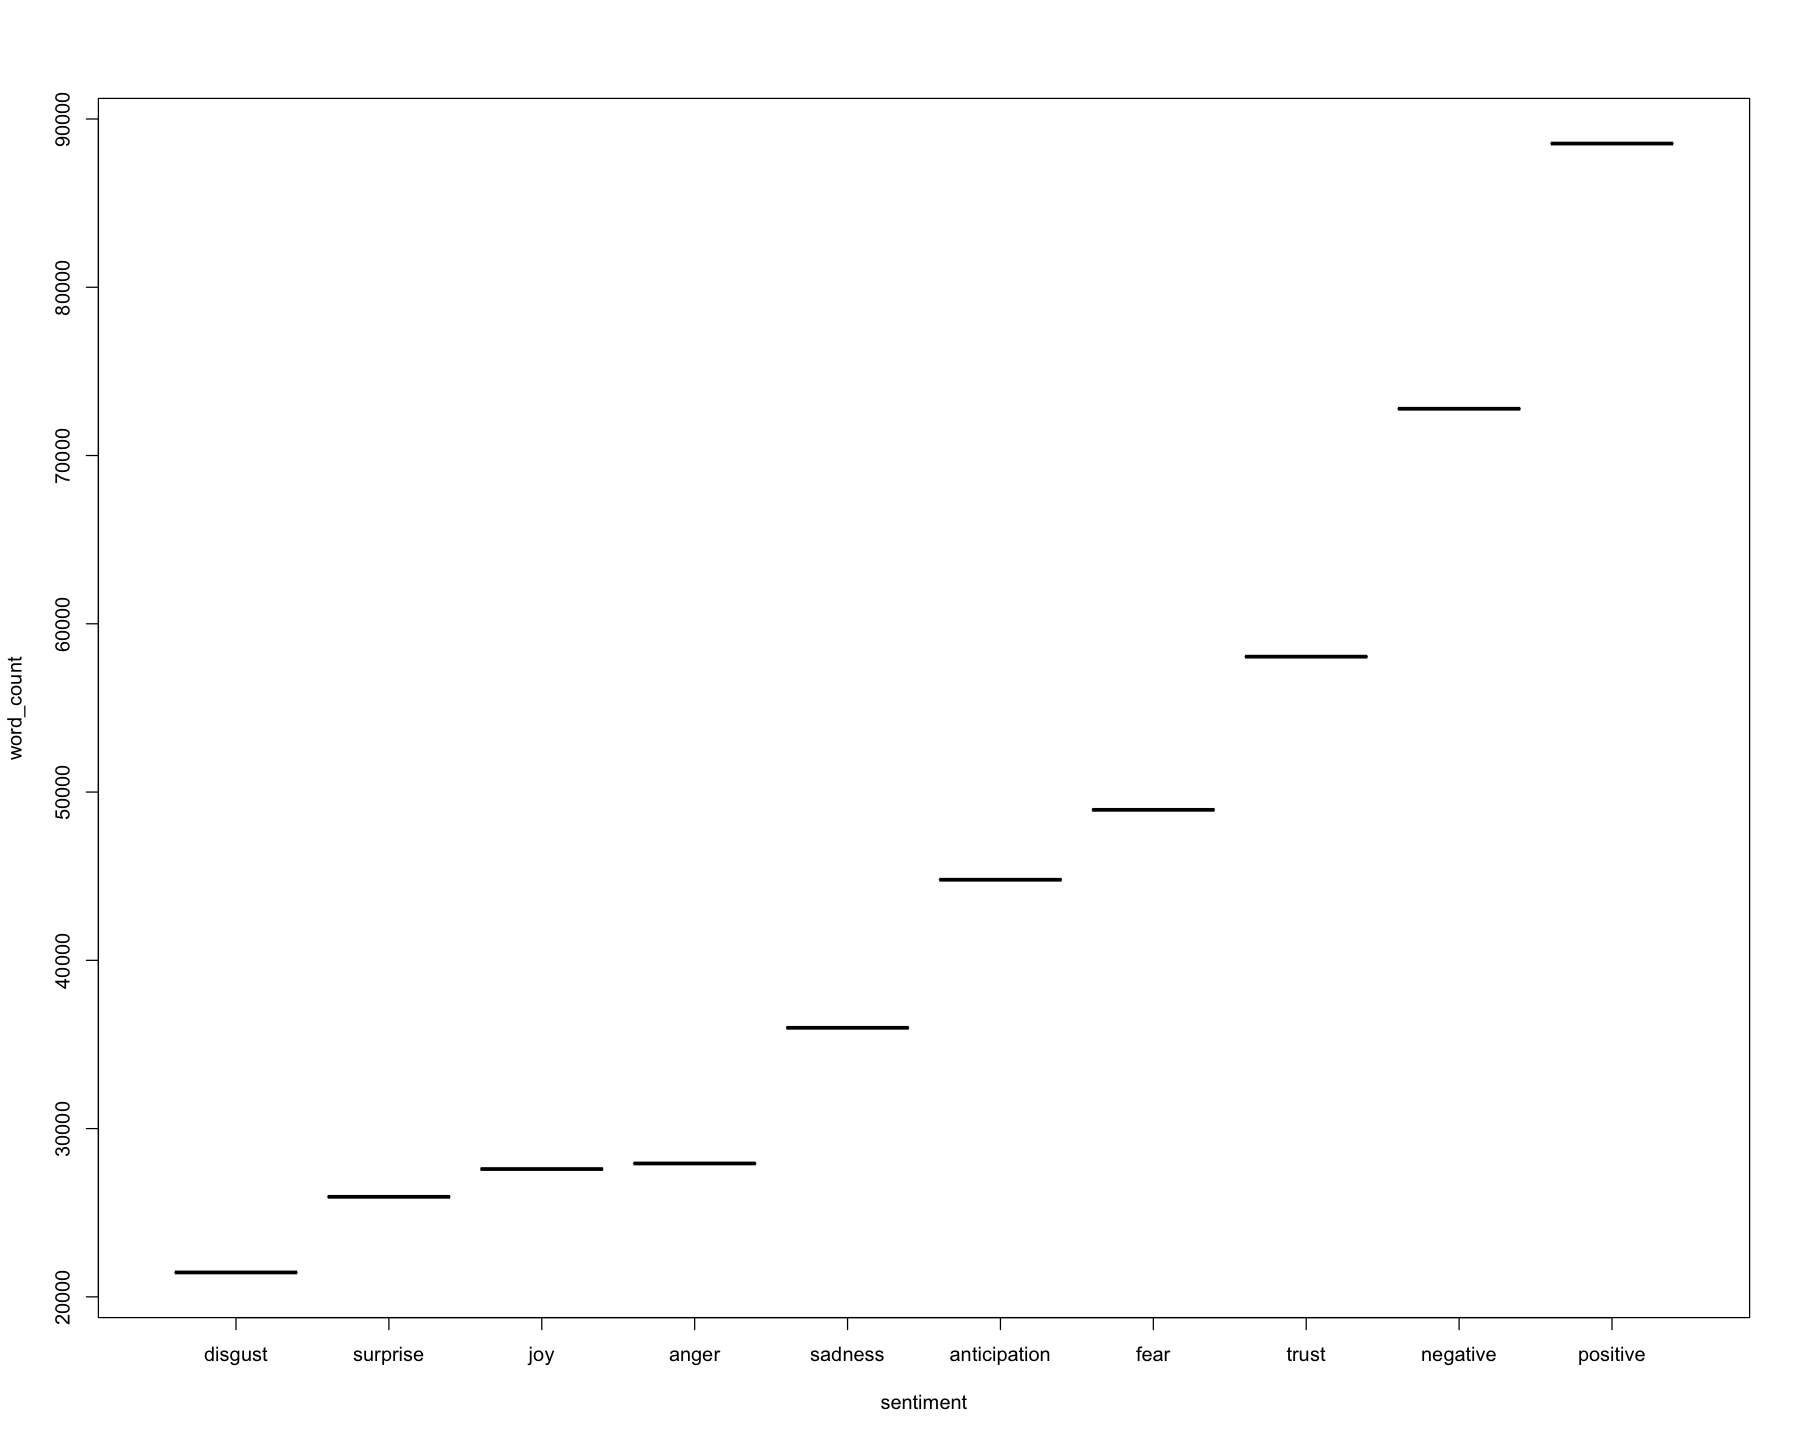

In [21]:
# group words by nrc sentiment category
nrc_plot <- covid_nrc %>%
  group_by(sentiment) %>%
  summarise(word_count = n()) %>%
  ungroup() %>%
  mutate(sentiment = reorder(sentiment, word_count))

# make a plot of the nrc sentiments for words in twitter dataset
ggplot(nrc_plot, aes(sentiment, word_count, fill = -word_count)) +
  geom_col() +
  guides(fill = FALSE) + 
  labs(x = NULL, y = "Word Count") +
  ggtitle("NRC Sentiment") +
  theme(legend.position = "none", 
          plot.title = element_text(size = 14, hjust = 0.5),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14)) +
  coord_flip()
  
plot(nrc_plot)

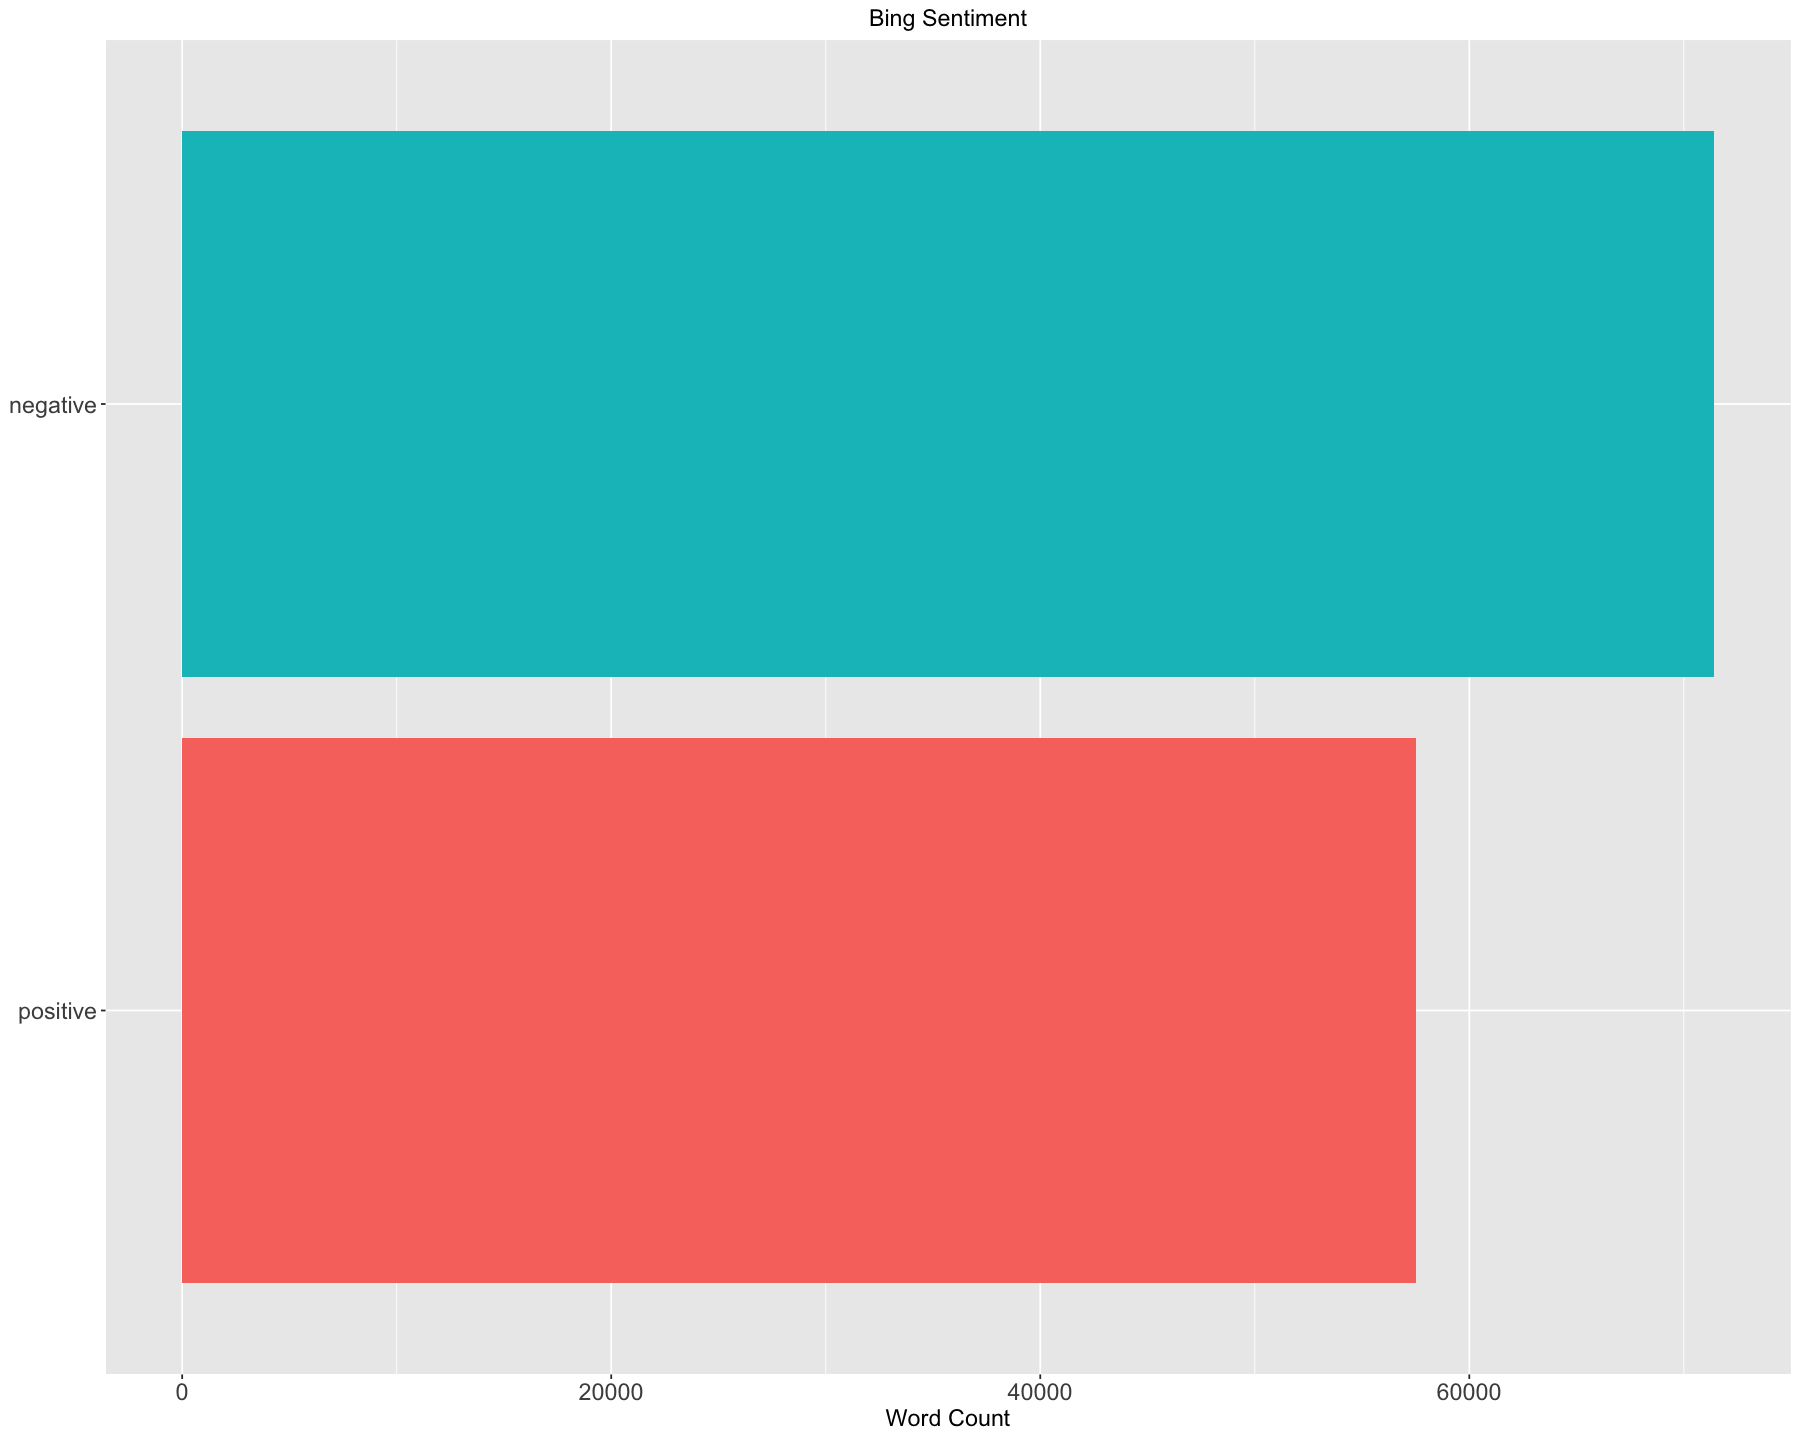

In [22]:
# group words into bing binary sentiments
bing_plot <- covid_bing %>%
  group_by(sentiment) %>%
  summarise(word_count = n()) %>%
  ungroup() %>%
  mutate(sentiment = reorder(sentiment, word_count))

# make a plot of bing sentiments
ggplot(bing_plot, aes(sentiment, word_count, fill = sentiment)) +
  geom_col() +
  guides(fill = FALSE) +
  labs(x = NULL, y = "Word Count") +
  ggtitle("Bing Sentiment") +
  theme(legend.position = "none", 
          plot.title = element_text(size = 14, hjust = 0.5),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14)) +
  coord_flip()

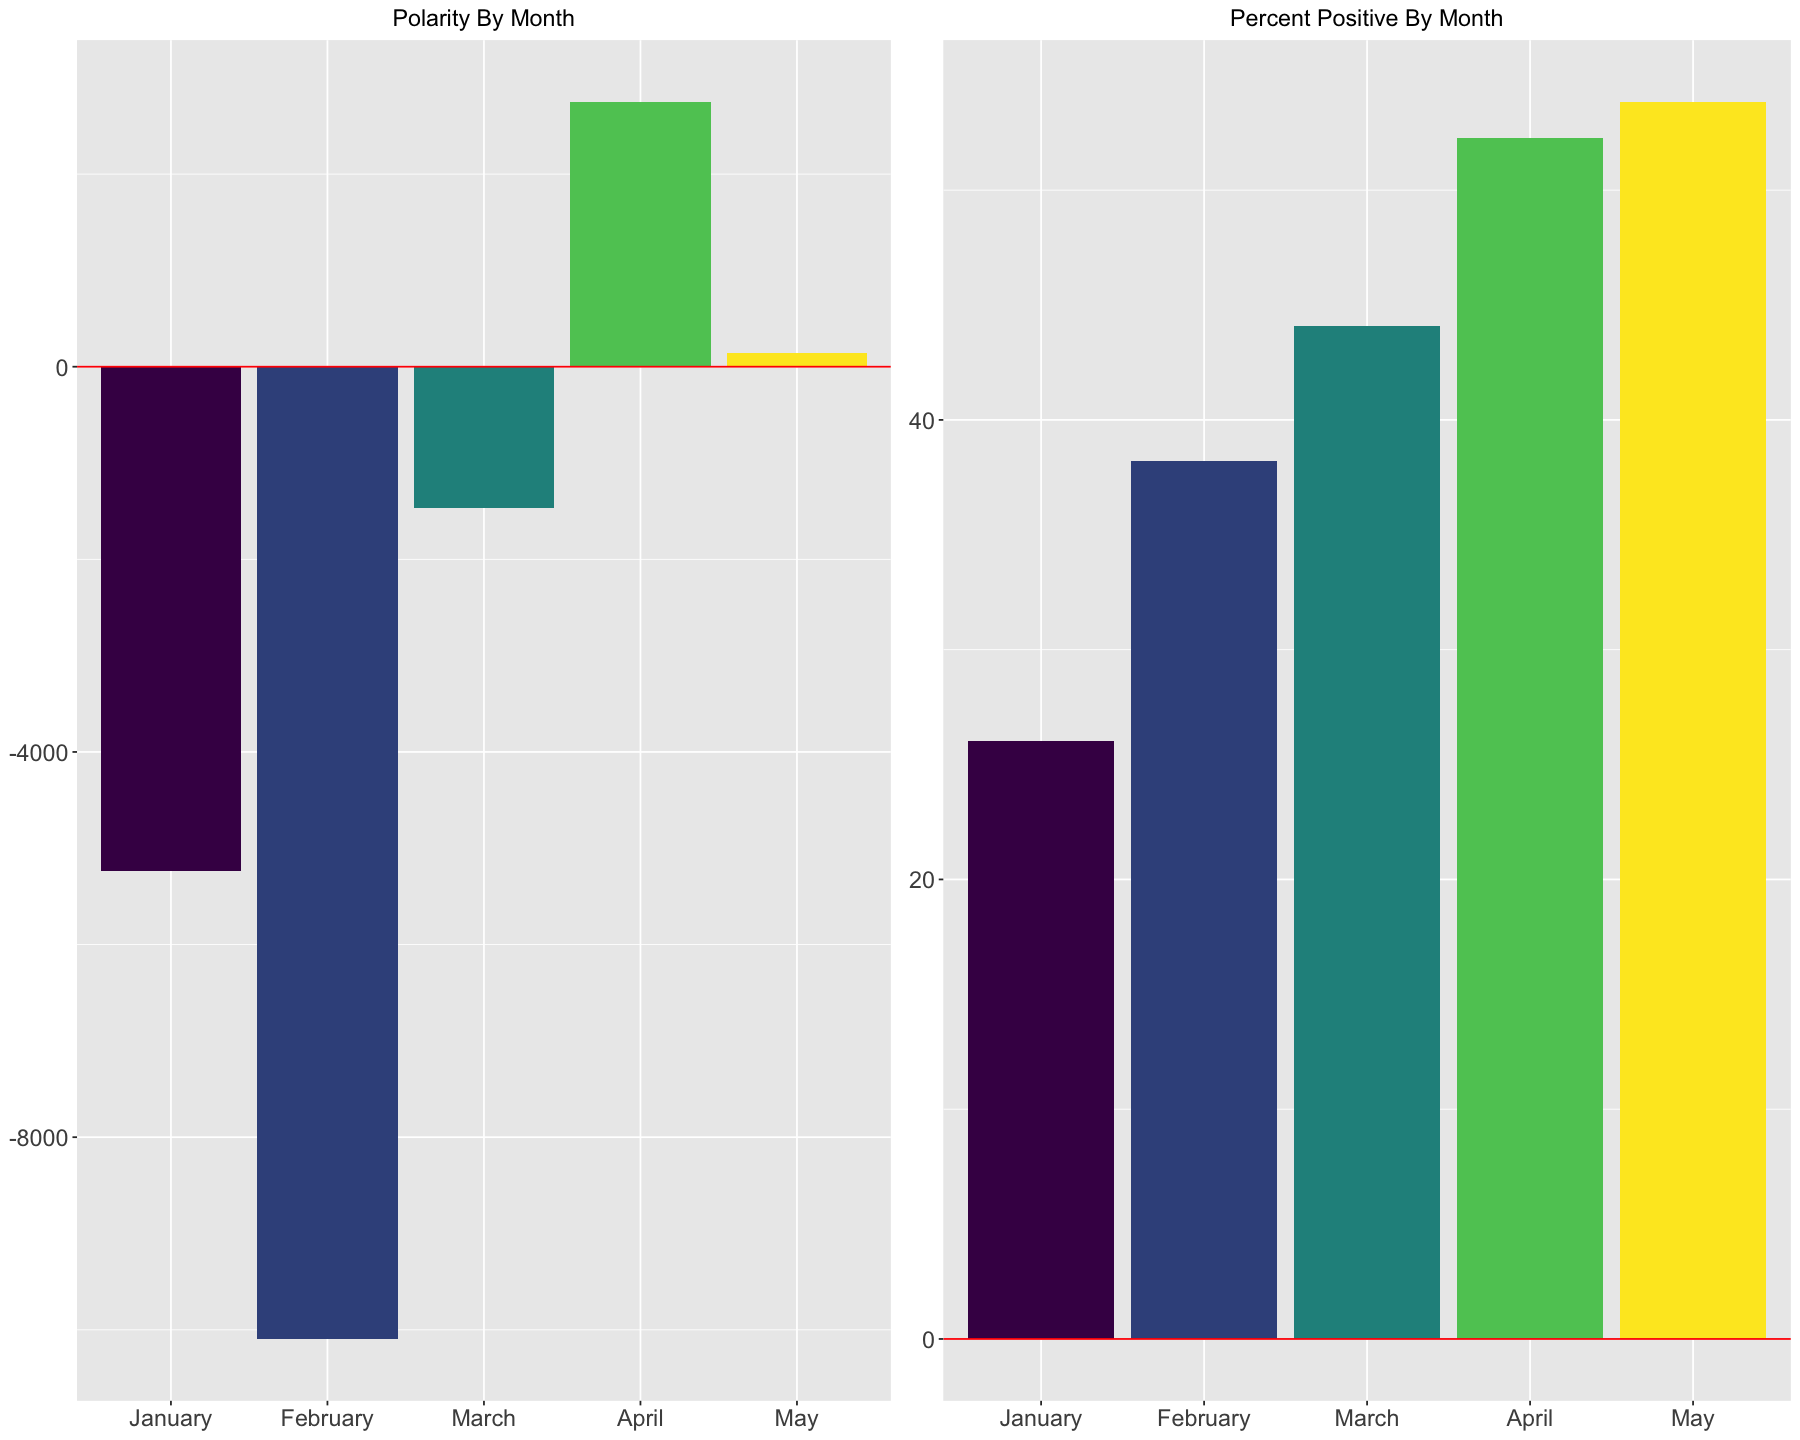

In [23]:
# create a polarity classification by month
covid_polarity_month <- covid_bing %>%
  count(sentiment, month) %>%
  spread(sentiment, n, fill = 0) %>% #  separate the sentiments into columns
  mutate(polarity = positive - negative, # create a polarity (positive - negative) field
    percent_positive = positive / (positive + negative) * 100)

#Polarity by month
plot1 <- covid_polarity_month %>%
  ggplot( aes(month, polarity, fill = month)) +
  geom_col() +
  geom_hline(yintercept = 0, color = "red") +
  theme(plot.title = element_text(size = 11)) +
  xlab(NULL) + ylab(NULL) +
  ggtitle("Polarity By Month") +
  theme(legend.position = "none", 
          plot.title = element_text(size = 14, hjust = 0.5),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14))

#Percent positive by month
plot2 <- covid_polarity_month %>%
  ggplot( aes(month, percent_positive, fill = month)) +
  geom_col() +
  geom_hline(yintercept = 0, color = "red") +
  theme(plot.title = element_text(size = 11)) +
  xlab(NULL) + ylab(NULL) +
  ggtitle("Percent Positive By Month") +
  theme(legend.position = "none", 
          plot.title = element_text(size = 14, hjust = 0.5),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14))

grid.arrange(plot1, plot2, ncol = 2)
options(repr.plot.width=15, repr.plot.height=12)

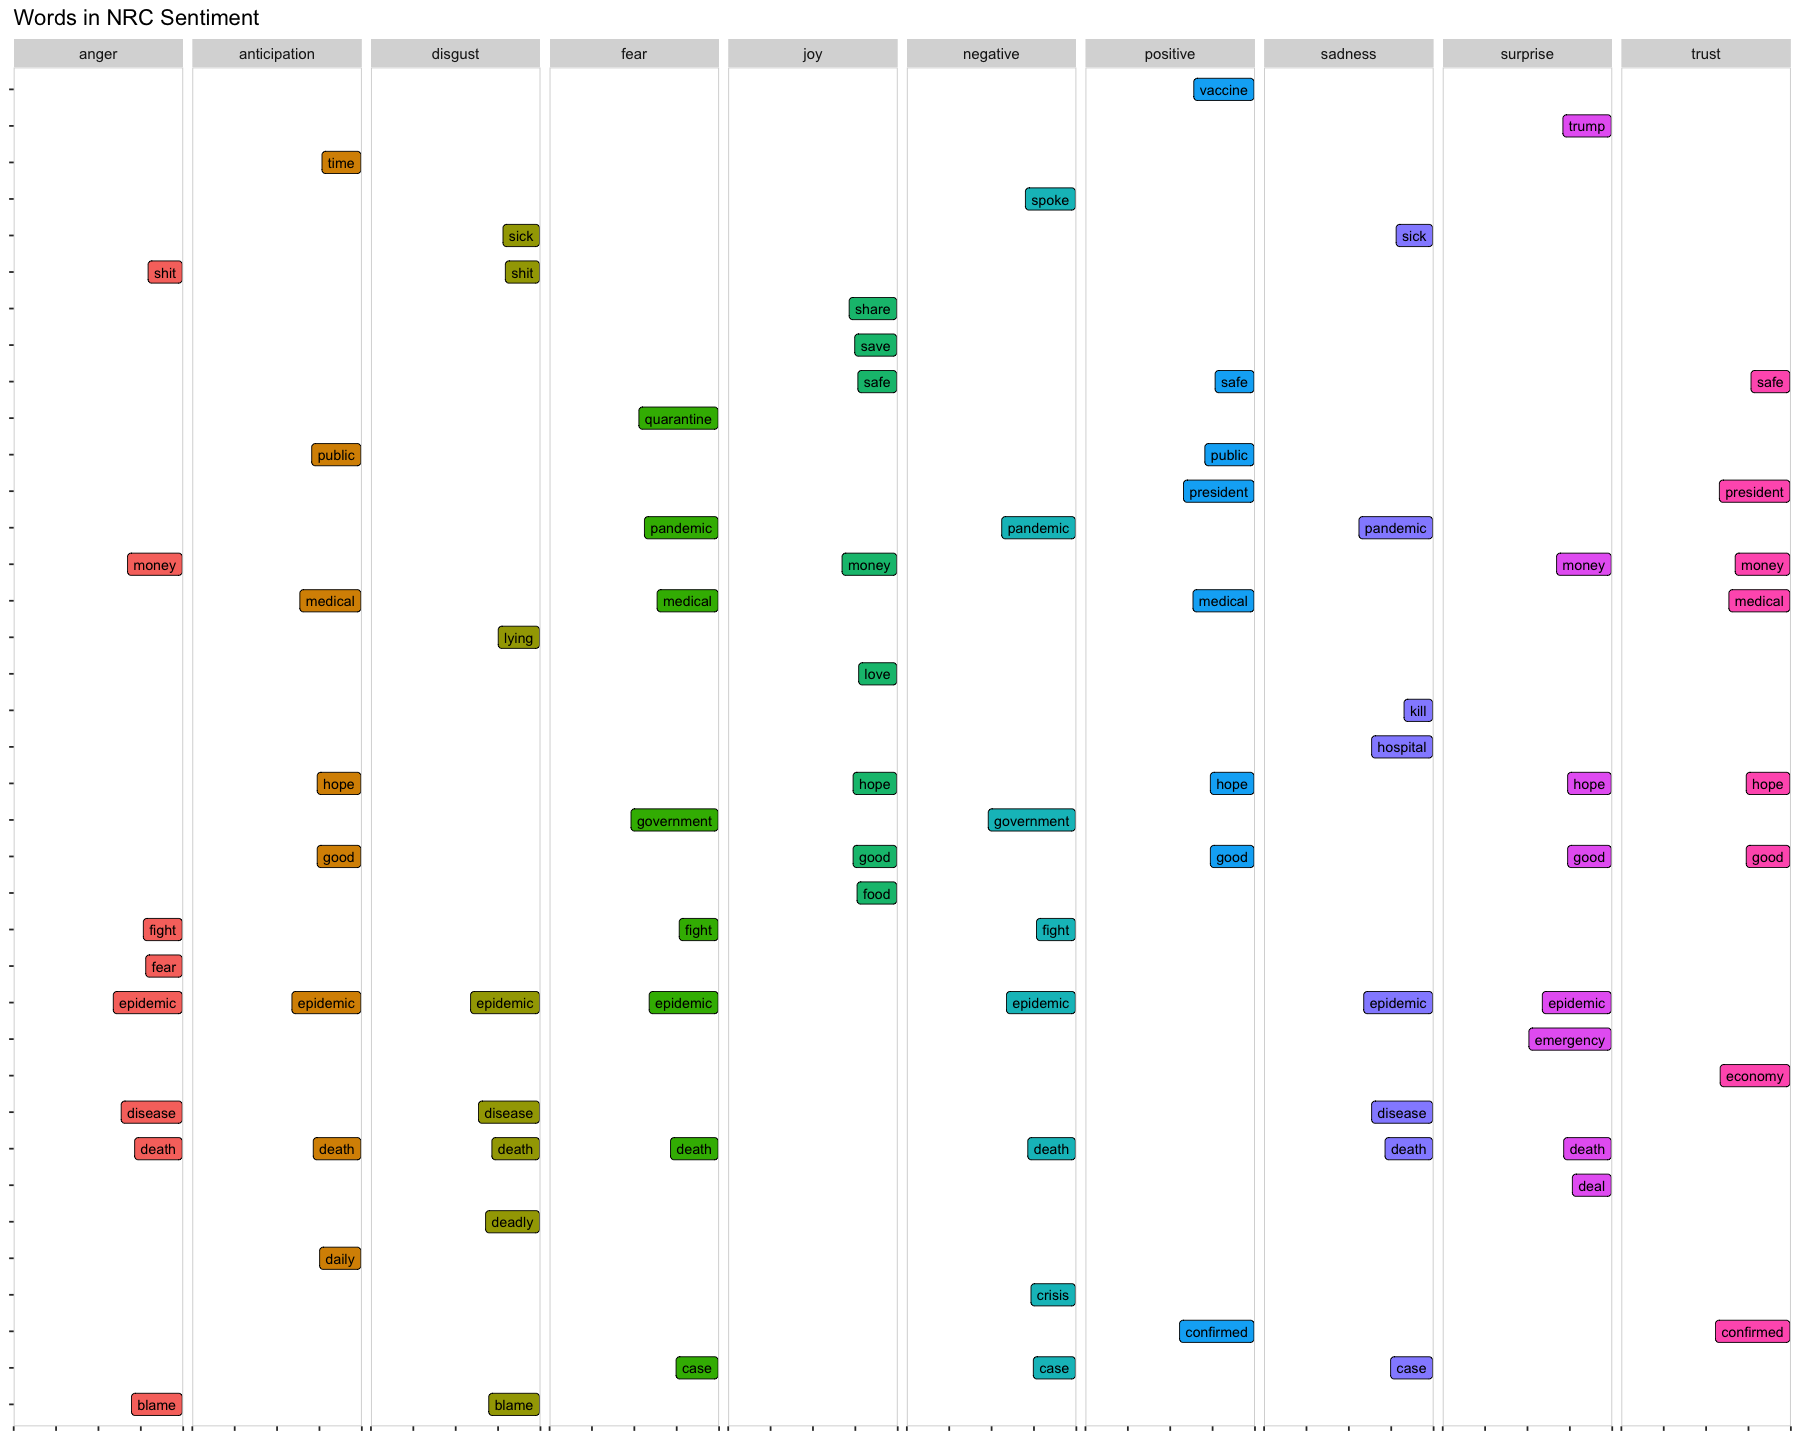

In [24]:
# look at the top words that match the NRC lexicon for this period
plot_words <- covid_nrc %>%
  group_by(sentiment) %>%
  count(word, sort = TRUE) %>%
  arrange(desc(n)) %>%
  slice(seq_len(8)) %>%
  ungroup()

# plot the words that fall within each of the NRC sentiment categories
plot_words %>%
  ggplot(aes(word, 1, label = word, fill = sentiment )) +
  geom_point(color = "transparent") + #plot the words, not the points
  geom_label_repel(force = 1,nudge_y = .5,  
                   direction = "y",
                   box.padding = 0.04,
                   segment.color = "transparent",
                   size = 3) +   #Make sure the labels don't overlap
  facet_grid(~sentiment) +
  theme(axis.text.y = element_blank(), axis.text.x = element_blank(),
        axis.title.x = element_text(size = 6),
        panel.grid = element_blank(), panel.background = element_blank(),
        panel.border = element_rect("lightgray", fill = NA),
        strip.text.x = element_text(size = 9),
        legend.position = "none") +
  xlab(NULL) + ylab(NULL) +
  ggtitle("Words in NRC Sentiment") +
  coord_flip()

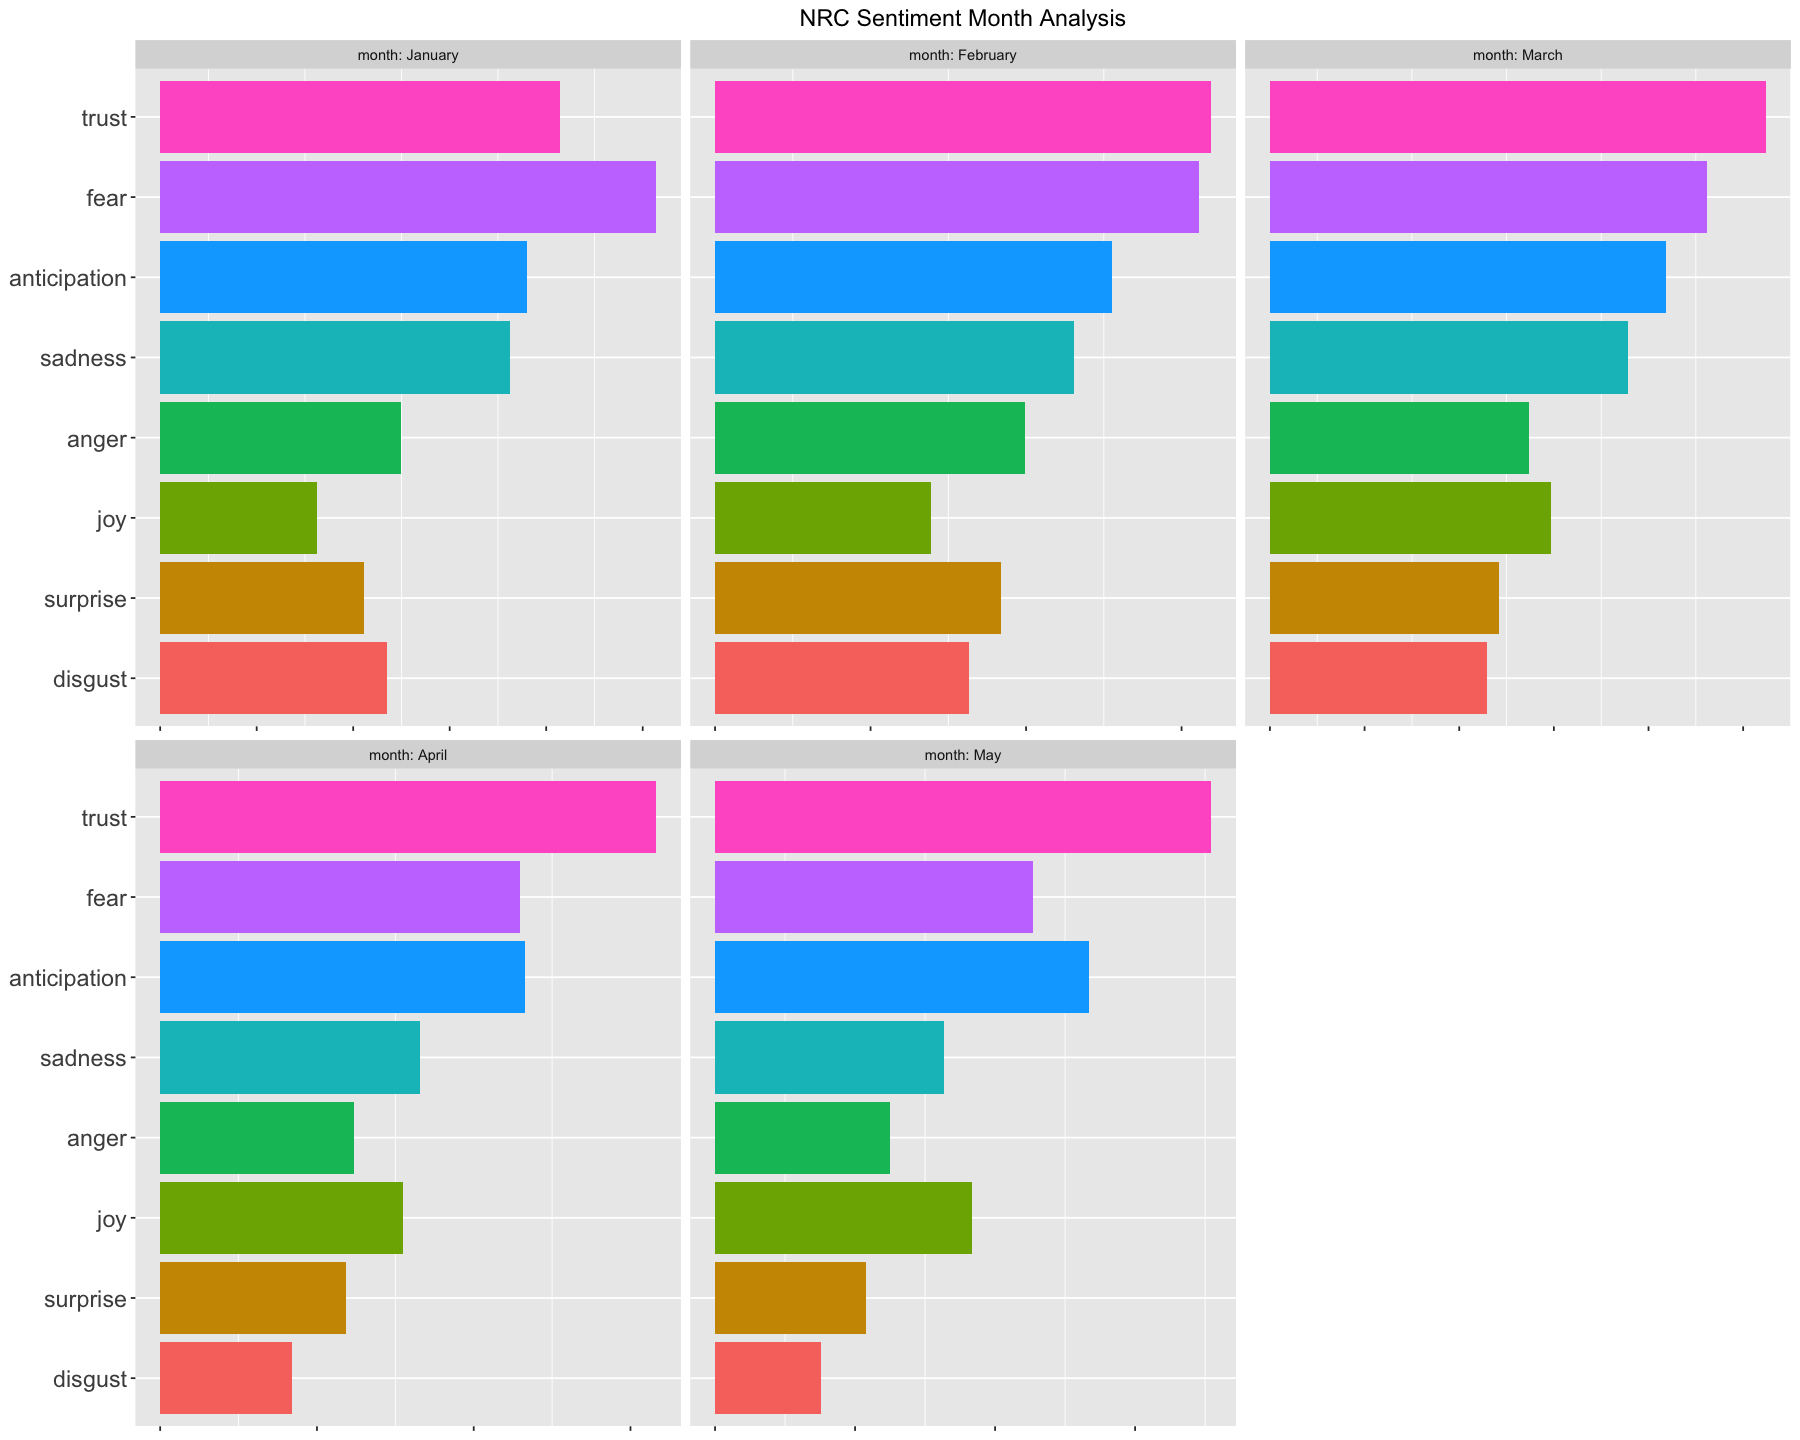

In [25]:
# NRC sentiments by month
covid_nrc_sub %>%
  count(month, sentiment) %>%
  mutate(sentiment = reorder(sentiment, n), song = reorder(month, n)) %>%
  ggplot(aes(sentiment, n, fill = sentiment)) +
  geom_col() +
  facet_wrap(~ month, scales = "free_x", labeller = label_both) +
  theme(panel.grid.major.x = element_blank(),
        axis.text.x = element_blank()) +
  labs(x = NULL, y = NULL) +
  ggtitle("NRC Sentiment Month Analysis") +
  theme(legend.position = "none", 
          plot.title = element_text(size = 14, hjust = 0.5),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14)) +

  coord_flip()

### Bigram Sentiment Analysis

In [26]:
# create bigram dataframe 
covid_bigrams <- covid_tweets %>%
  unnest_tokens(bigram, Tweet_Content, token = "ngrams", n = 2)

# seperate both words in the bigram
bigrams_separated <- covid_bigrams %>%
  separate(bigram, c("word1", "word2"), sep = " ")

# filter any stop words or undesirable words within bigram
bigrams_filtered <- bigrams_separated %>%
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word) %>%
  filter(!word1 %in% undesirable_words) %>%
  filter(!word2 %in% undesirable_words)

# also filter out the cases where the two words are the same
bigram_month <- bigrams_filtered %>%
  filter(word1 != word2) %>%
  unite(bigram, word1, word2, sep = " ") %>%
  inner_join(covid_tweets) %>%
  count(bigram, month, sort = TRUE) %>%
  group_by(month) %>%
  slice(seq_len(7)) %>%
  ungroup() %>%
  arrange(month, n) %>%
  mutate(row = row_number())

Joining, by = c("Tweet_ID", "User", "Date_Created", "Location", "Latitude", "Longitude", "day", "month", "hour")



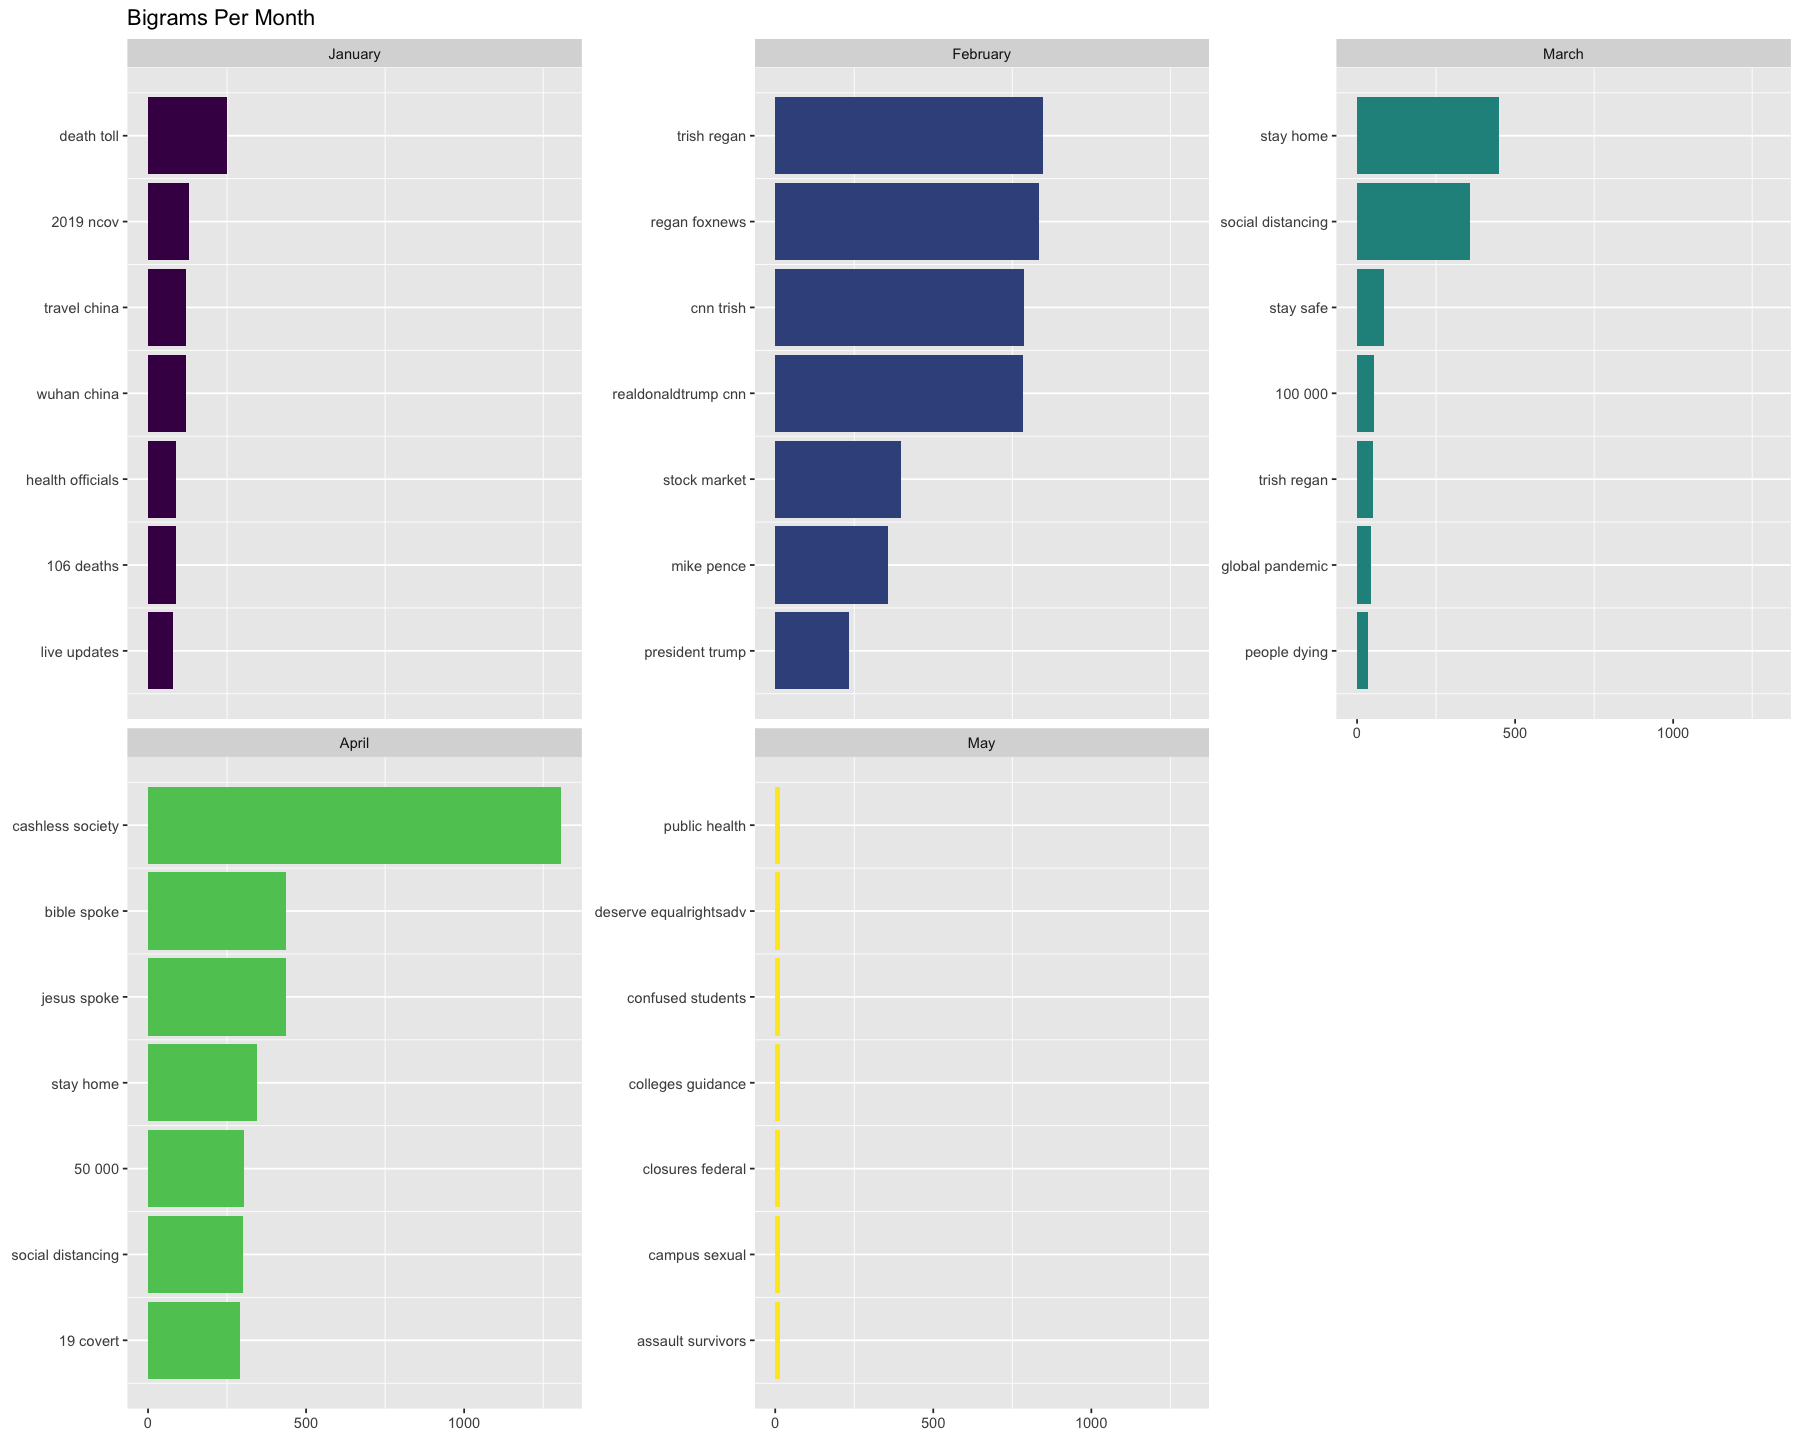

In [27]:
# plot bigram 
bigram_month %>%
  ggplot(aes(row, n, fill = month)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~month, scales = "free_y") +
  xlab(NULL) + ylab(NULL) +
  scale_x_continuous(  # This handles replacement of row
      breaks = bigram_month$row, # Notice need to reuse data frame
      labels = bigram_month$bigram) +
  theme(panel.grid.major.x = element_blank()) +
  ggtitle("Bigrams Per Month") +
  coord_flip()

### Pairwise Correlation
How often words appear together relative to how often they appear separately

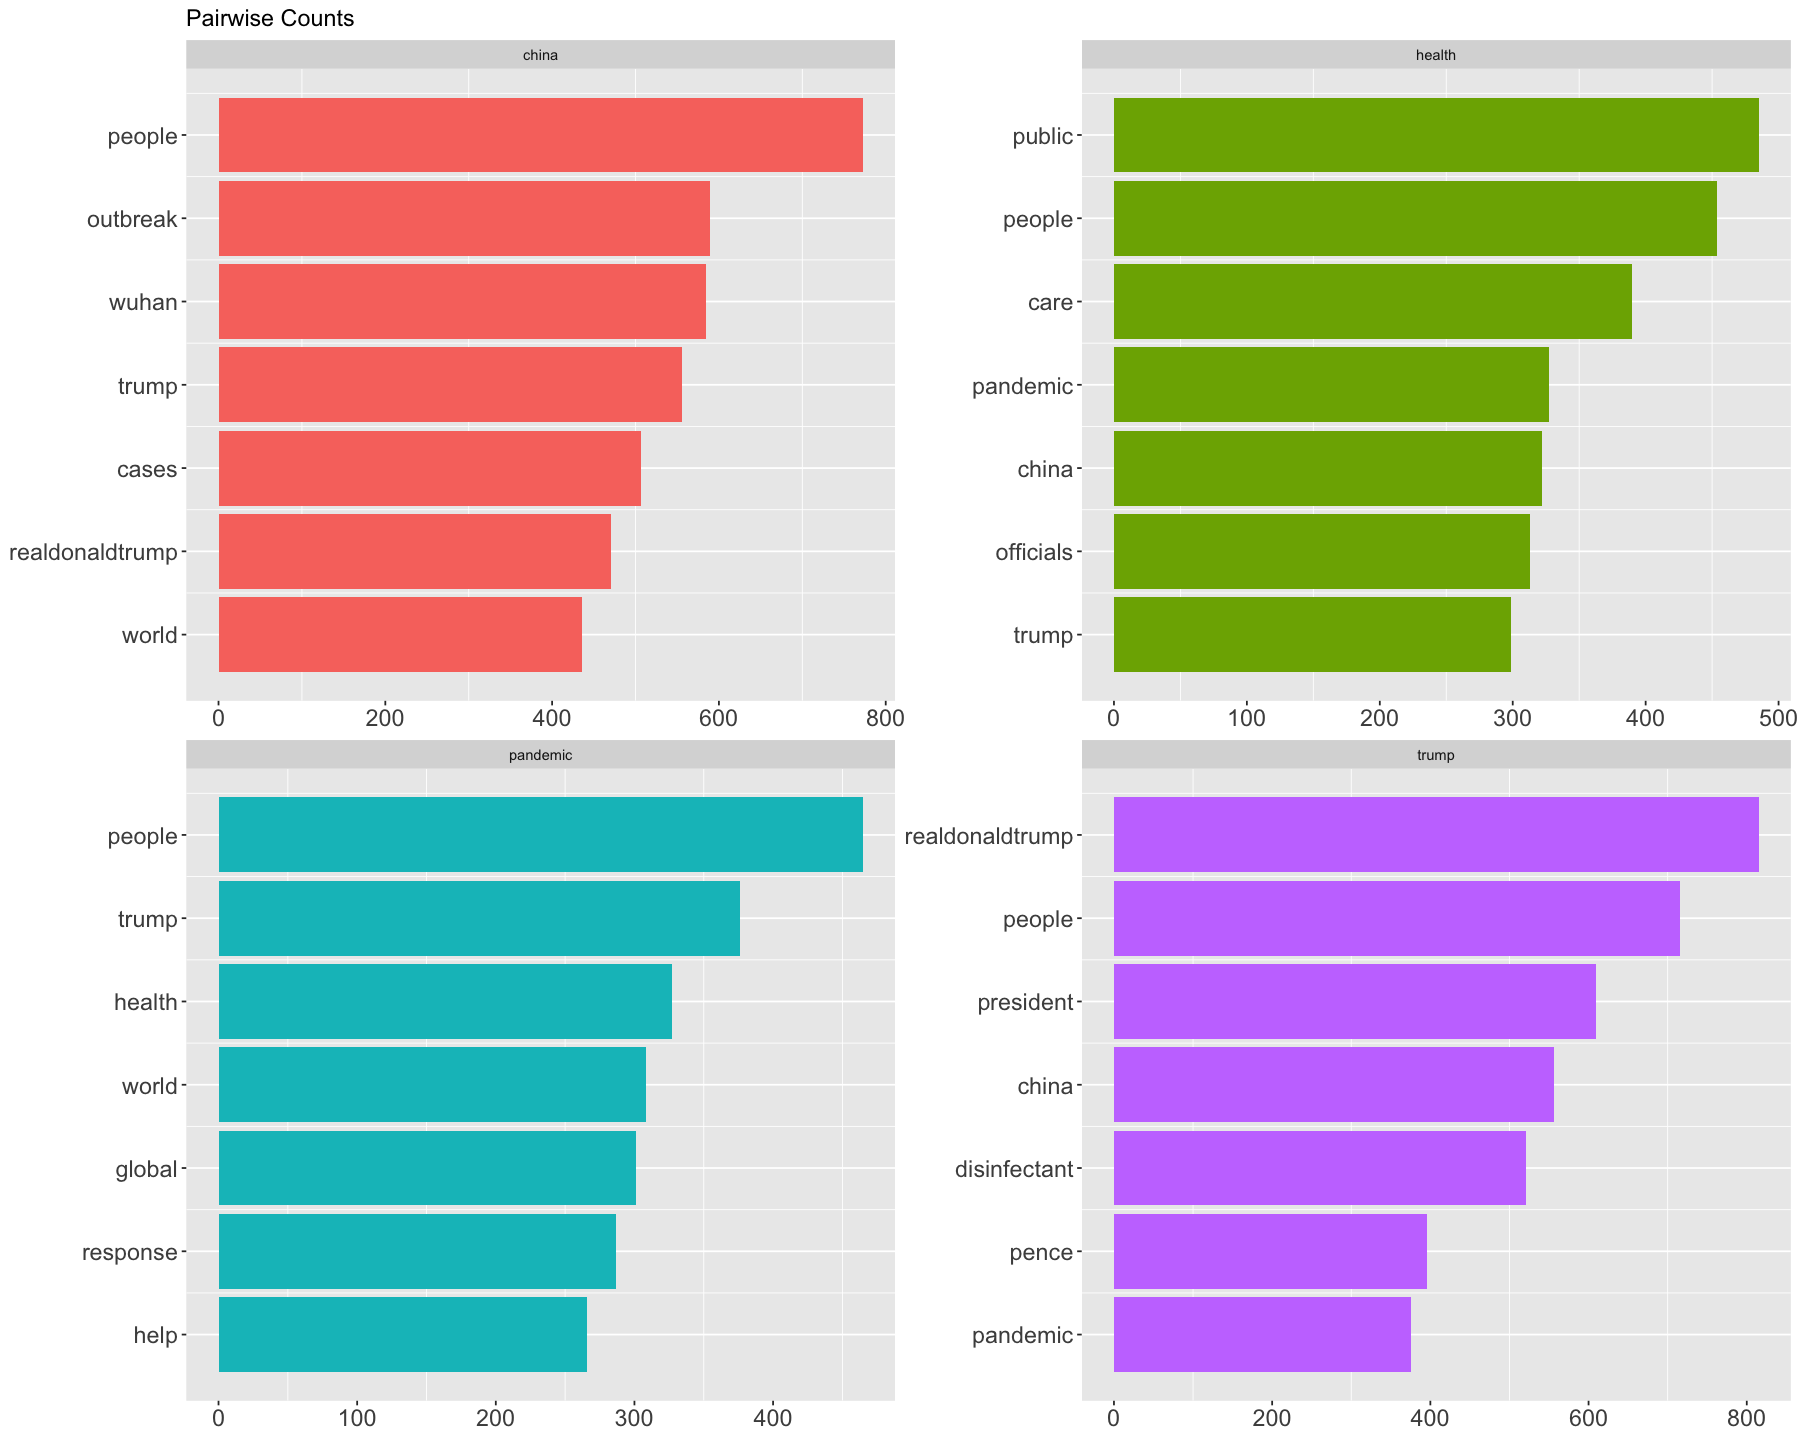

In [28]:
# plot pairwise counts for interesting words
pwc <- covid_tweets_filtered %>%
  filter(n() >= 20) %>%  #High counts
  pairwise_count(word, User, sort = TRUE) %>%
  filter(item1 %in% c("trump", "health", "pandemic", "china")) %>%
  group_by(item1) %>%
  slice(seq_len(7)) %>%
  ungroup() %>%
  mutate(row = -row_number()) #Descending order


pwc %>%
  ggplot(aes(row, n, fill = item1)) +
  geom_bar(stat = "identity", show.legend = FALSE) +
  facet_wrap(~item1, scales = "free") +
  scale_x_continuous( #This handles replacement of row
                    breaks = pwc$row, #Notice need to reuse data frame
                    labels = pwc$item2) +
  theme(panel.grid.major.x = element_blank(), 
          plot.title = element_text(size = 14),
          axis.text=element_text(size=14),
          axis.title=element_text(size=14)) +
  xlab(NULL) + ylab(NULL) +
  ggtitle("Pairwise Counts") +
  coord_flip()

Selecting by correlation



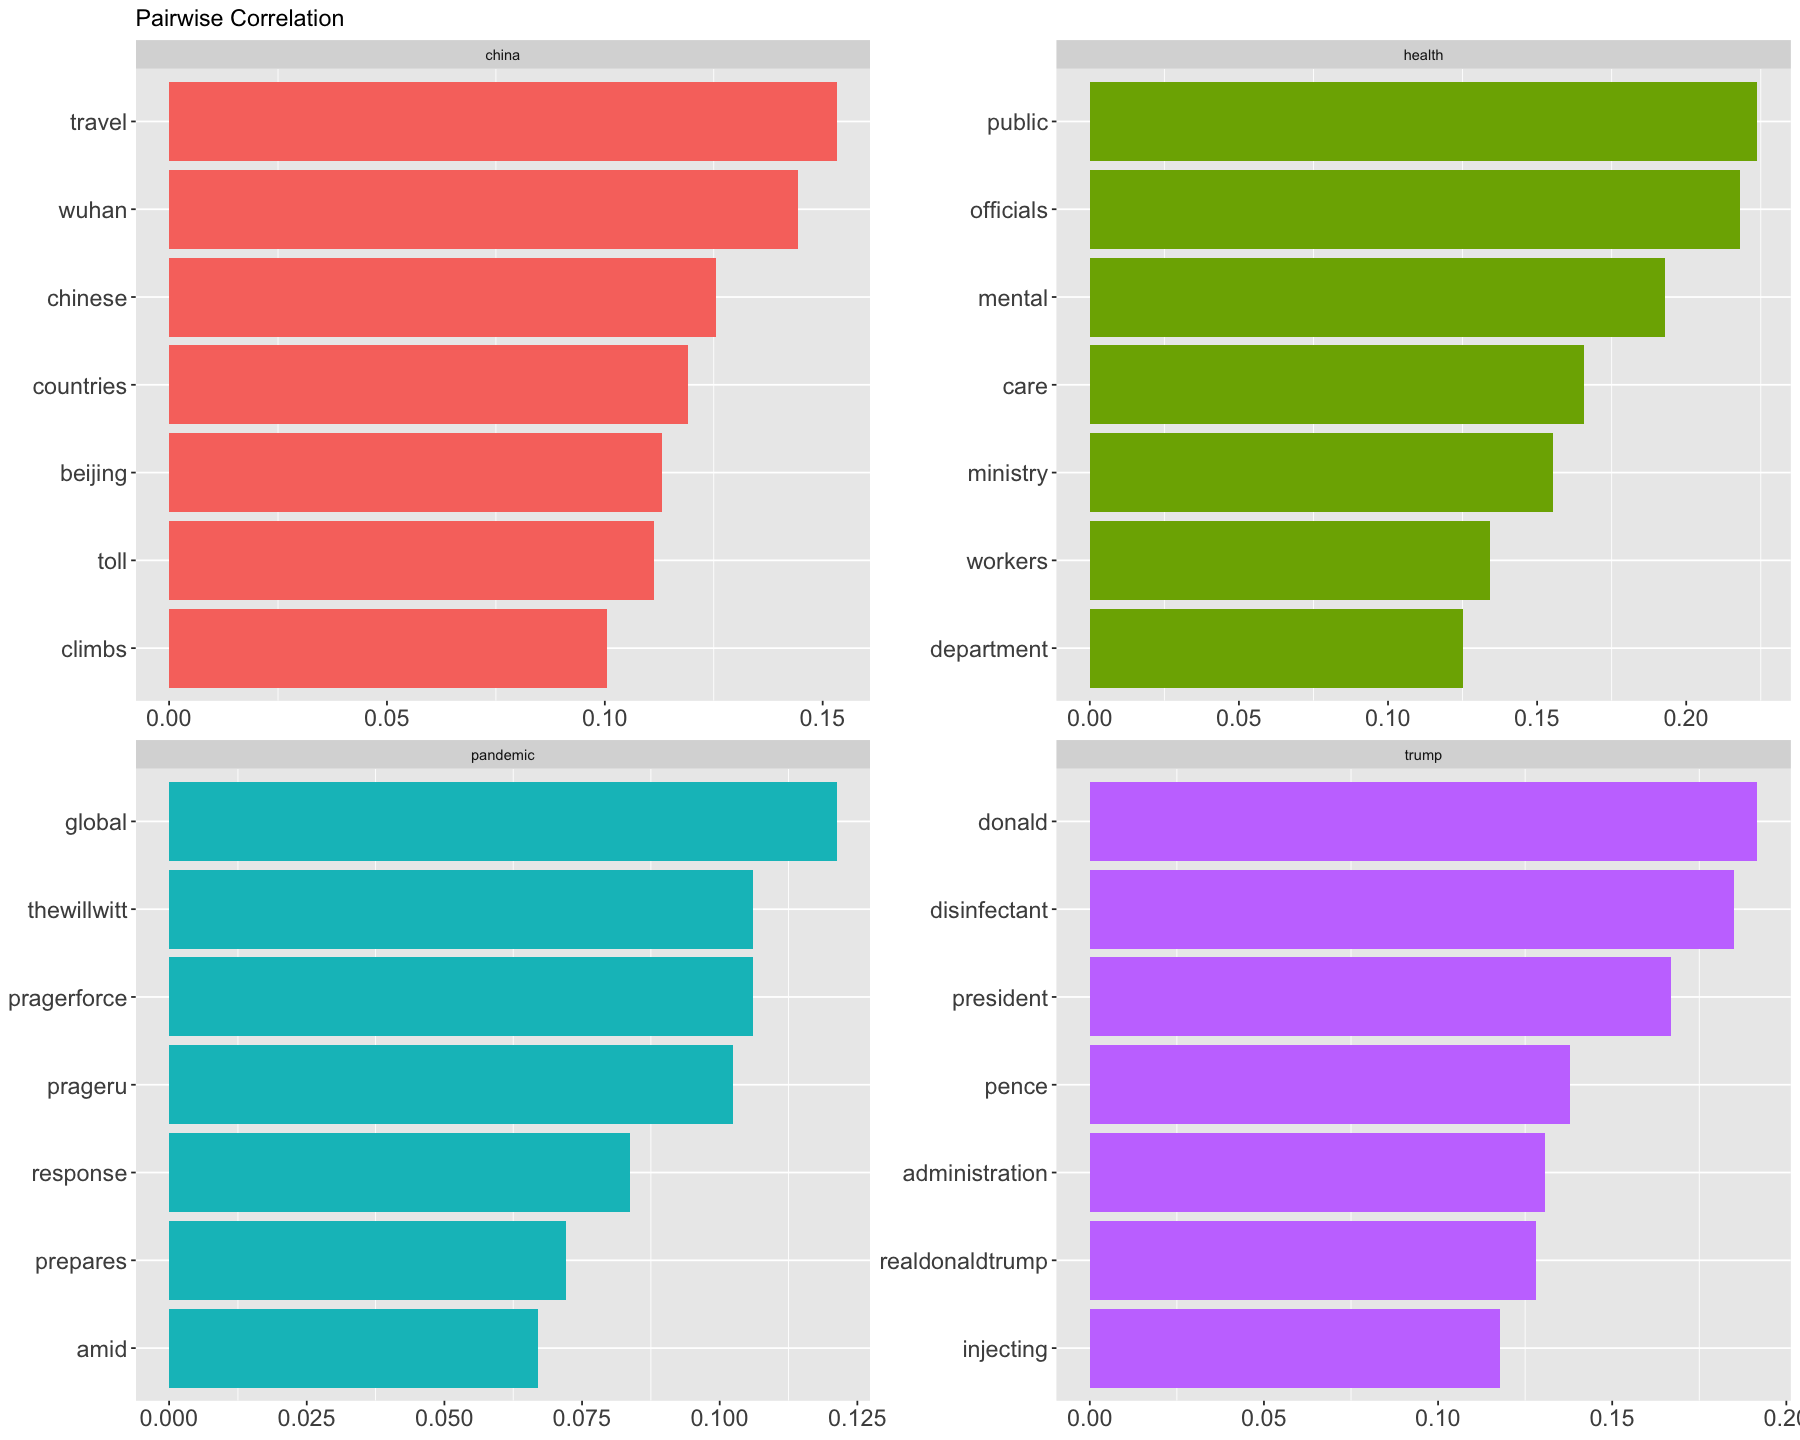

In [29]:
# plot pairwise correlation for interesting words
covid_tweets_filtered %>%
  group_by(word) %>%
  filter(n() >= 20) %>%
  pairwise_cor(word, User, sort = TRUE) %>%
  filter(item1 %in% c("trump", "health", "pandemic", "china")) %>%
  group_by(item1) %>%
  top_n(7) %>%
  ungroup() %>%
  mutate(item2 = reorder(item2, correlation)) %>%
  ggplot(aes(item2, correlation, fill = item1)) +
  geom_bar(stat = 'identity', show.legend = FALSE) +
  facet_wrap(~item1, scales = 'free') +
  theme(panel.grid.major.x = element_blank(),
        plot.title = element_text(size = 14),
        axis.text=element_text(size=14),
        axis.title=element_text(size=14)) +
  xlab(NULL) + ylab(NULL) +
  ggtitle("Pairwise Correlation") +
  coord_flip()

### Topic Modeling with Machine Learning <br>
We will use Latent Dirichlet Allocation (LDA) which discovers different topics underlying a collection of documents, where each document is a collection of words.

In [30]:
# filter only tweets in last month because of limited computing power
covid_tweets_apr <- covid_tweets %>%
  filter(month %in% "April")

# create corpus object
twt_corpus <- Corpus(VectorSource(covid_tweets_apr$Tweet_Content))

# remove undesirable words
twt_corpus <- tm_map(twt_corpus, removeWords, undesirable_words)

# Get the lengths and make sure we only create a DTM for tweets with
doc_lengths <- rowSums(as.matrix(DocumentTermMatrix(twt_corpus)))

#create document-term matrix for LDA algorithm
dtm <- DocumentTermMatrix(twt_corpus[doc_lengths > 0])

Warning message in tm_map.SimpleCorpus(twt_corpus, removeWords, undesirable_words):
“transformation drops documents”


In [31]:
k <- 4 #number of topics
seed = 1234 #necessary for reproducibility

# fit LDA model using GIBBS method
lda <- LDA(dtm, k = k, method = "GIBBS", control = list(seed = seed))

# check the words within the themes
terms(lda, 10)

Topic 1,Topic 2,Topic 3,Topic 4
now,people,pandemic,cases
one,trump,help,deaths
home,time,health,see
make,realdonaldtrump,society,news
need,disinfectant,read,day
world,work,cashless,latest
stay,china,crisis,today
good,times,support,total
great,president,towards,patients
thanks,bleach,check,daily


β (“beta”), from the model:

In [32]:
topic_probs <- tidy(lda, matrix = "beta")
topic_probs

topic,term,beta
<int>,<chr>,<dbl>
1,danger,6.487684e-07
2,danger,6.371528e-04
3,danger,6.421486e-07
4,danger,6.532011e-07
1,don,6.487684e-07
2,don,3.748225e-03
3,don,3.570988e-03
4,don,6.532011e-07
1,essentials,2.082547e-04


In [34]:
assignments <- augment(lda, data = dtm)
assignments

document,term,count,.topic
<chr>,<chr>,<dbl>,<dbl>
1,danger,1,2
1,don,1,2
1,essentials,1,1
1,exercise,1,2
1,family,1,1
1,home,2,1
1,lives,2,1
1,must,1,3
1,nhs,1,1


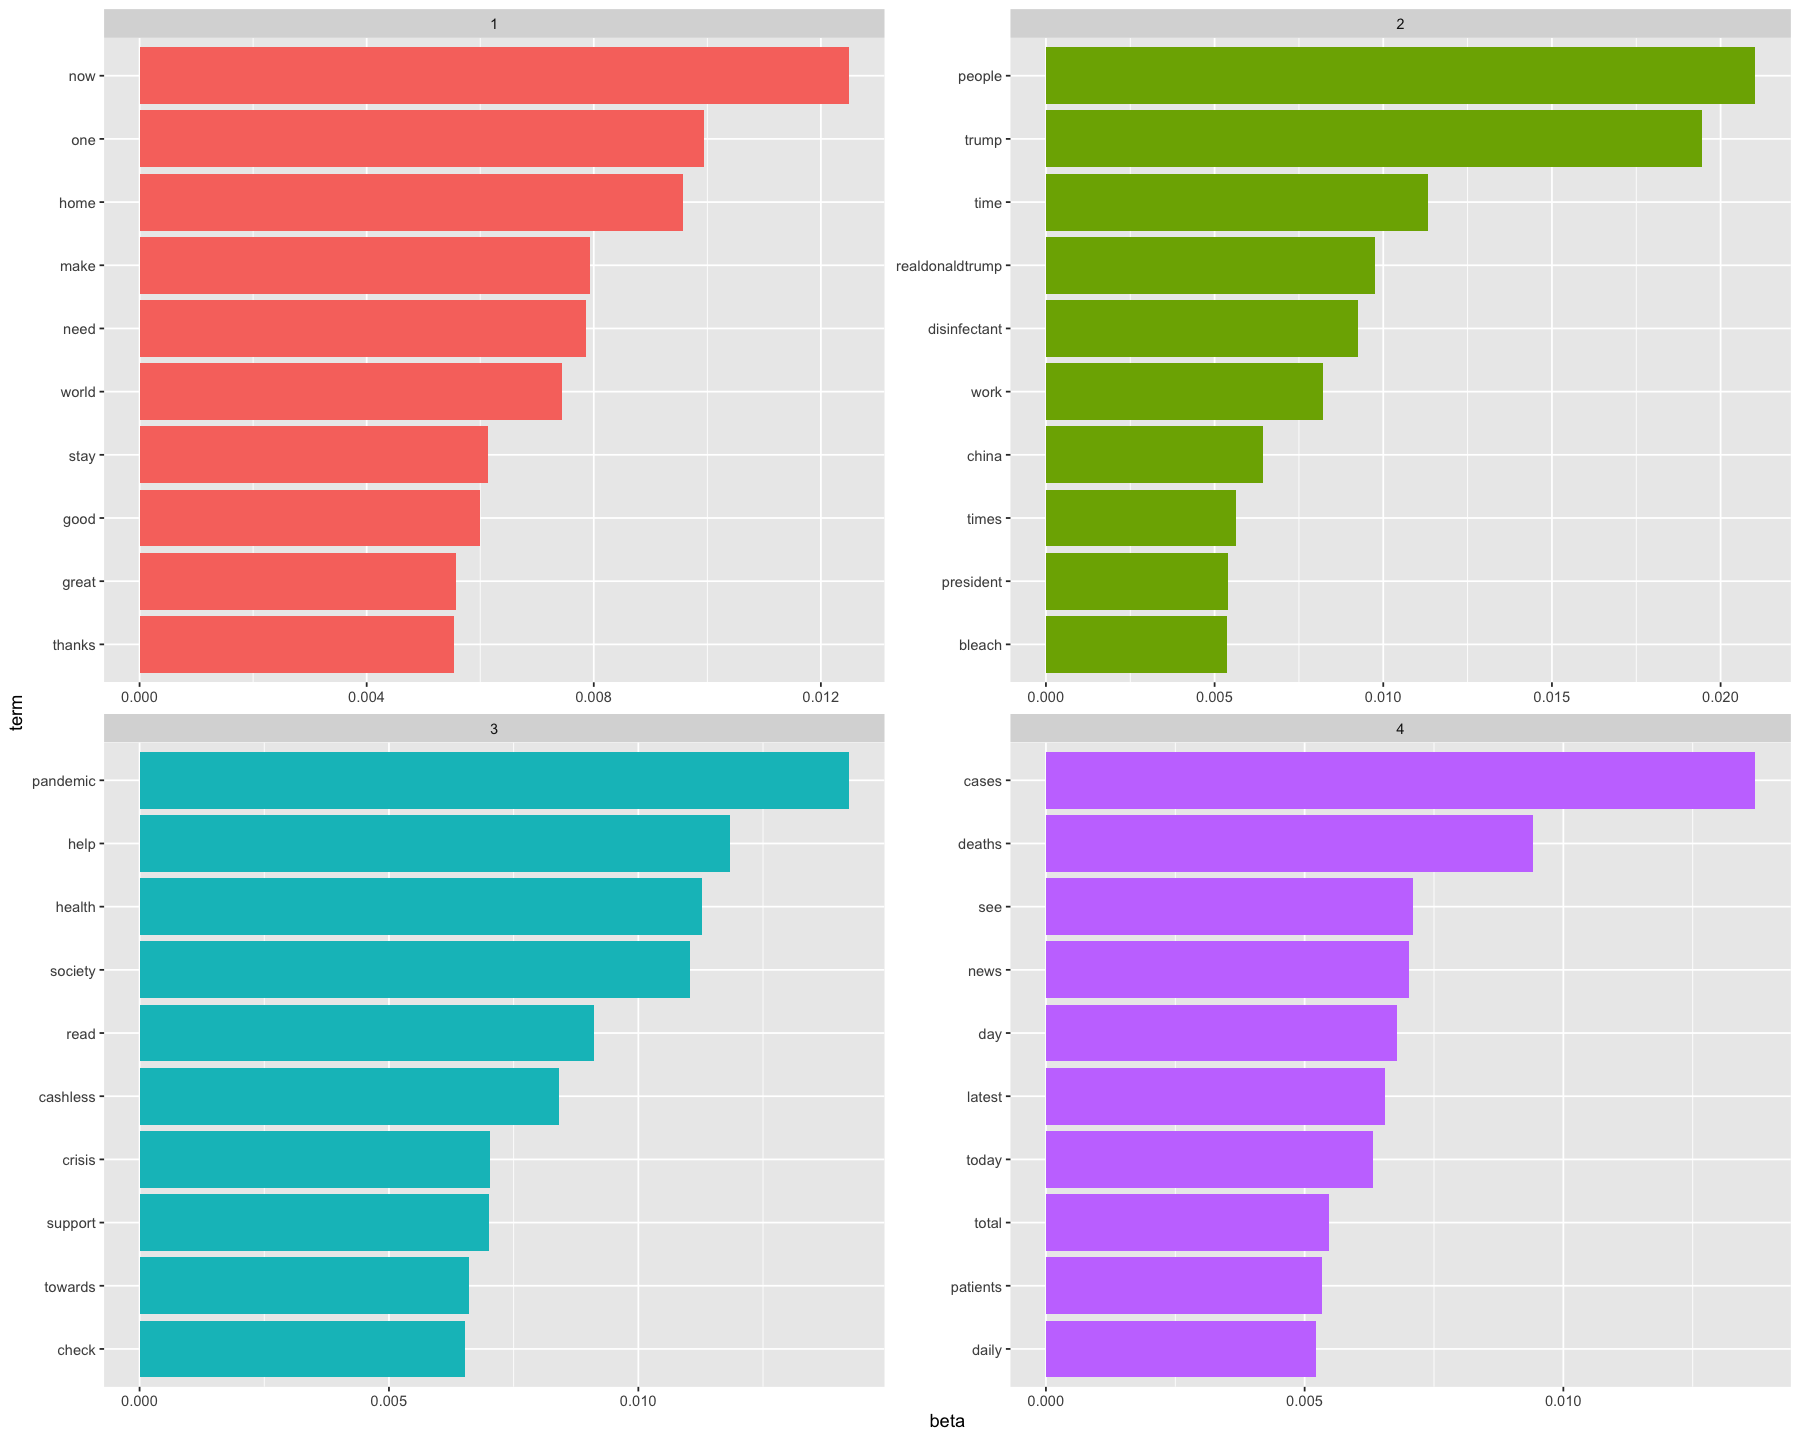

In [35]:
ap_top_terms <- topic_probs %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

ap_top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip() +
  scale_x_reordered()